# NYC Yellow Taxi Trip Analysis

### How well can we model the number of taxi trips in a New York neighborhood in a 1 hour time period?

Predicting how many taxi trips originate in a certain neighborhood has several benefits:

* Taxi companies can predict how many taxis should be available in a neighborhood
* Passengers in a particular neighborhood can know the likelihood of being able to hail a taxi during a certain time of the day

In this project, I have used several open datasets to predict the number of taxi trips in a specific New York neighborhood in a 1 hour time period.

The datasets are the following:
* NYC yellow taxi trips
* NYC neighborhoods dataset
* Historic weather data

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import numpy as np
import csv
import sqlite3
import time
import json
from sklearn import cluster
from sklearn import feature_selection, linear_model
from mpl_toolkits.basemap import Basemap
from geopy.distance import vincenty, great_circle
import statsmodels.formula.api as smf
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

C:\Users\Anirban\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Monthly data analysis - Comparison between Yellow taxis and Uber

As part of exploratory analysis, I initially looked at how taxi trips vary during different months in a year. I follow analyses such as number of total trips at each hour, number of trips as a function of day of the week, and number of trips on each day of the month.

Here we look at the number of trips recorded by NYC Yellow taxis on a monthly basis. Records for 2013, 2014, and 2015 are analyzed. We also look at the number of Uber trips for the months of April to September 2014.

Each count list is created by iterating through all records of the corresponding month. Finally, a dataframe is created that contains all trip count data and this data is loaded into a csv.

It is <b>not necessary to run the next 5 code blocks</b> since the resulting dataframe has been loaded to a new file which can be directly loaded.

In [16]:
def parse_data(file_path, file_name, year, taxi_co, count_df):
    '''
    Counts the number of records in the files, formats it into a dataframe.
    Args:
        file_path (str): Path of the file.
        file_name (str): Name of the file without month number.
        year (int): year of acquired data
        taxi_co (str): Name of the taxi company whose data is being parsed
        count_df (DataFrame): Existing dataframe to which the data for the year will be added
    Returns:
        count_df (DataFrame): Dataframe containing the trips data for the year.
        
    '''
    count_list = []
    for i in range(12):
        file_path_iter = file_path + '/' + file_name + '_' + '%d'%year + '-%02d.csv'%(i+1)
        print file_path_iter

        try: 
            trip_data_file = open(file_path_iter, 'r')
            trip_data = csv.reader(trip_data_file)
            header = trip_data.next()

            count = 0
            for j in trip_data:
                count+=1
            count_list.append(count)
            trip_data_file.close()
        
        except:
            count_list.append(0)
    
    count_df['%d'%year + taxi_co + '_trips'] = count_list
    return count_df

We create a dataframe containing all the trip count data for 2013, 2014, and 2015 yellow taxi trips.

In [20]:
count_df = pd.DataFrame(columns = ['Month'])
count_df['Month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec']

new_count_df = count_df

new_count_df = parse_data('../nyc_taxi_files/2013-data','yellow_tripdata',2013,'TLC',new_count_df)
new_count_df = parse_data('../nyc_taxi_files/2014-data','yellow_tripdata',2014,'TLC',new_count_df)
new_count_df = parse_data('../nyc_taxi_files/2015-data','yellow_tripdata',2015,'TLC',new_count_df)

new_count_df

../nyc_taxi_files/2013-data/yellow_tripdata_2013-01.csv
../nyc_taxi_files/2013-data/yellow_tripdata_2013-02.csv
../nyc_taxi_files/2013-data/yellow_tripdata_2013-03.csv
../nyc_taxi_files/2013-data/yellow_tripdata_2013-04.csv
../nyc_taxi_files/2013-data/yellow_tripdata_2013-05.csv
../nyc_taxi_files/2013-data/yellow_tripdata_2013-06.csv
../nyc_taxi_files/2013-data/yellow_tripdata_2013-07.csv
../nyc_taxi_files/2013-data/yellow_tripdata_2013-08.csv
../nyc_taxi_files/2013-data/yellow_tripdata_2013-09.csv
../nyc_taxi_files/2013-data/yellow_tripdata_2013-10.csv
../nyc_taxi_files/2013-data/yellow_tripdata_2013-11.csv
../nyc_taxi_files/2013-data/yellow_tripdata_2013-12.csv
../nyc_taxi_files/2014-data/yellow_tripdata_2014-01.csv
../nyc_taxi_files/2014-data/yellow_tripdata_2014-02.csv
../nyc_taxi_files/2014-data/yellow_tripdata_2014-03.csv
../nyc_taxi_files/2014-data/yellow_tripdata_2014-04.csv
../nyc_taxi_files/2014-data/yellow_tripdata_2014-05.csv
../nyc_taxi_files/2014-data/yellow_tripdata_2014

Month  2013TLC_trips  2014TLC_trips  2015TLC_trips
0    Jan       14776615       13782493       12748986
1    Feb       13990176       13063792       12450521
2    Mar       15749228       15428128       13351609
3    Apr       15100468       14618760       13071789
4    May       15285049       14774042       13158262
5    Jun       14385456       13813030       12324935
6    Jul       13823840       13106366       11562783
7    Aug       12597109       12688878       11130304
8    Sep       14107693       13374017       11225063
9    Oct       15004556       14232488       12315488
10   Nov       14388451       13218217       11312676
11   Dec       13971118       13014162       11460573

We append the April to September data for Uber to this dataframe. The final dataframe is saved in a csv file and can be loaded in order to run the subsequent analysis

In [21]:
# uber_count_df = pd.DataFrame(columns = ['Month'])
# uber_count_df['Month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec']

new_count_df = parse_data('../nyc_taxi_files/uber-trip-data','uber-raw-data',2014,'Uber',new_count_df)

new_count_df

../nyc_taxi_files/uber-trip-data/uber-raw-data_2014-01.csv
../nyc_taxi_files/uber-trip-data/uber-raw-data_2014-02.csv
../nyc_taxi_files/uber-trip-data/uber-raw-data_2014-03.csv
../nyc_taxi_files/uber-trip-data/uber-raw-data_2014-04.csv
../nyc_taxi_files/uber-trip-data/uber-raw-data_2014-05.csv
../nyc_taxi_files/uber-trip-data/uber-raw-data_2014-06.csv
../nyc_taxi_files/uber-trip-data/uber-raw-data_2014-07.csv
../nyc_taxi_files/uber-trip-data/uber-raw-data_2014-08.csv
../nyc_taxi_files/uber-trip-data/uber-raw-data_2014-09.csv
../nyc_taxi_files/uber-trip-data/uber-raw-data_2014-10.csv
../nyc_taxi_files/uber-trip-data/uber-raw-data_2014-11.csv
../nyc_taxi_files/uber-trip-data/uber-raw-data_2014-12.csv


Month  2013TLC_trips  2014TLC_trips  2015TLC_trips  2014Uber_trips
0    Jan       14776615       13782493       12748986               0
1    Feb       13990176       13063792       12450521               0
2    Mar       15749228       15428128       13351609               0
3    Apr       15100468       14618760       13071789          564516
4    May       15285049       14774042       13158262          652435
5    Jun       14385456       13813030       12324935          663844
6    Jul       13823840       13106366       11562783          796121
7    Aug       12597109       12688878       11130304          829275
8    Sep       14107693       13374017       11225063         1028136
9    Oct       15004556       14232488       12315488               0
10   Nov       14388451       13218217       11312676               0
11   Dec       13971118       13014162       11460573               0

In [22]:
new_count_df.to_csv('../nyc_taxi_files/trip_count_all_years.csv',index=False)

In [23]:
new_count_df = pd.read_csv('../nyc_taxi_files/trip_count_all_years.csv')
new_count_df

Month  2013TLC_trips  2014TLC_trips  2015TLC_trips  2014Uber_trips
0    Jan       14776615       13782493       12748986               0
1    Feb       13990176       13063792       12450521               0
2    Mar       15749228       15428128       13351609               0
3    Apr       15100468       14618760       13071789          564516
4    May       15285049       14774042       13158262          652435
5    Jun       14385456       13813030       12324935          663844
6    Jul       13823840       13106366       11562783          796121
7    Aug       12597109       12688878       11130304          829275
8    Sep       14107693       13374017       11225063         1028136
9    Oct       15004556       14232488       12315488               0
10   Nov       14388451       13218217       11312676               0
11   Dec       13971118       13014162       11460573               0

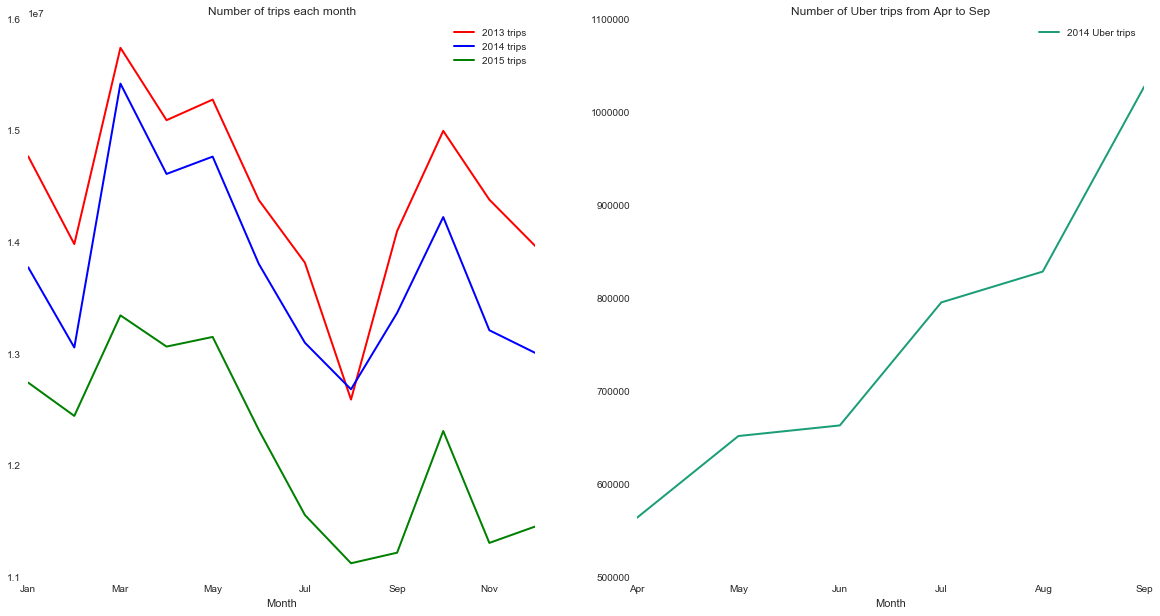

In [24]:
plt.figure(figsize=(20,10))

ax1 = plt.subplot(121)
count_df.plot(x='Month', y='2013TLC_trips', kind='line', color = 'red', ax=ax1, label='2013 trips')
count_df.plot(x='Month', y='2014TLC_trips', kind='line', color = 'blue', ax=ax1, label='2014 trips')
count_df.plot(x='Month', y='2015TLC_trips', kind='line', color = 'green', ax=ax1, label='2015 trips')

ax1.set(title='Number of trips each month')

ax2 = plt.subplot(122)
count_df[count_df.Month.isin(['Apr','May','Jun','Jul','Aug','Sep'])].plot(x='Month', y='2014Uber_trips', kind='line', 
                                                                          ax=ax2, label='2014 Uber trips')
ax2.set(title='Number of Uber trips from Apr to Sep')

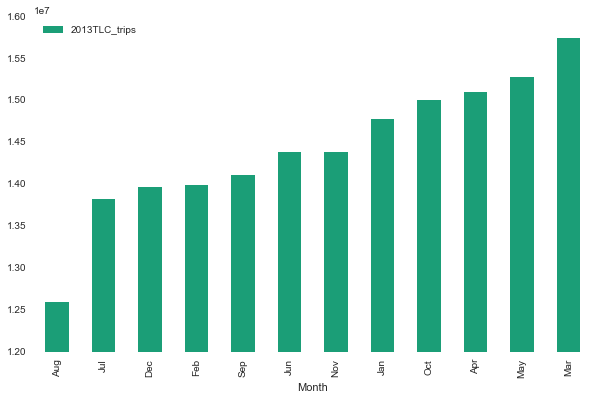

In [25]:
count_df_sorted=count_df.sort_values(by='2013TLC_trips')
count_df_sorted.plot(x='Month',y='2013TLC_trips',kind='bar',ylim=(1.2e7, 1.6e7))

### Trip data analysis for a single month

The following code blocks perform two tasks:

* Reads in the January trip and fare data for 2013 contained in two different files.
* Join both files using a merge operation based on unique identifiers 'medallion','hack_license','vendor_id', and 'pickup_datetime'

The two files contain <b> one-to-one mappings of records</b> corresponding to the same trips and so a plain merge using the primary keys will join the two files.

In [5]:
%%time

trip_data_file=pd.read_csv('../nyc_taxi_files/2013-data/yellow_tripdata_2013-01.csv')
trip_fare_file=pd.read_csv('../nyc_taxi_files/2013-data/trip_fare_01.csv')

Wall time: 2min 42s


In [34]:
trip_data_file.columns

Index([u'medallion', u'hack_license', u'vendor_id', u'rate_code',
       u'store_and_fwd_flag', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'trip_time_in_secs', u'trip_distance',
       u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude',
       u'dropoff_latitude'],
      dtype='object')

In [35]:
trip_fare_file.columns

Index([u'medallion', u' hack_license', u' vendor_id', u' pickup_datetime',
       u' payment_type', u' fare_amount', u' surcharge', u' mta_tax',
       u' tip_amount', u' tolls_amount', u' total_amount'],
      dtype='object')

In [7]:
trip_fare_file.rename(columns=lambda x: x.strip(), inplace = True)

In [37]:
trip_fare_file.columns

Index([u'medallion', u'hack_license', u'vendor_id', u'pickup_datetime',
       u'payment_type', u'fare_amount', u'surcharge', u'mta_tax',
       u'tip_amount', u'tolls_amount', u'total_amount'],
      dtype='object')

In [31]:
trip_data_file.tail()

medallion                      hack_license  \
14776610  B33E71CD9E8FE1BE3B70FEB6E807DD15  BAF57796E45D921BB23217E17A372FF6   
14776611  ED160B76D5349C8AC1ECF22CD4B8D538  3B93F6DA5DEBDE9560993FA624C4FF76   
14776612  D83F9AC0E33F6F19869C243BE6AB6FE5  85A55B6772275374EF90AC9457DC1F83   
14776613  04E59442A7DDBCE515E33CD355D866E7  7913172189931A1A1632562B10AB53C4   
14776614  D30BED60331C79E3F7ACD05B325ED42F  B5E1D2461A5BCC8819188DACEC17CD69   

         vendor_id  rate_code store_and_fwd_flag      pickup_datetime  \
14776610       CMT          1                  N  2013-01-06 04:58:23   
14776611       CMT          1                  N  2013-01-08 14:42:04   
14776612       CMT          1                  N  2013-01-10 13:29:23   
14776613       CMT          1                  N  2013-01-06 16:30:15   
14776614       CMT          1                  N  2013-01-05 20:38:46   

             dropoff_datetime  passenger_count  trip_time_in_secs  \
14776610  2013-01-06 05:11:24                1                781   
14776611  2013-01-08 14:50:27                1                503   
14776612  2013-01-10 13:34:45                1                321   
14776613  2013-01-06 16:42:26                1                730   
14776614  2013-01-05 20:43:06                1                260   

          trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
14776610            3.3        -73.989029        40.759327         -73.953743   
14776611            1.0        -73.993042        40.733990         -73.982483   
14776612            0.9        -73.979553        40.785011         -73.968262   
14776613            1.3        -73.968002        40.762161         -73.985992   
14776614            0.8        -73.982224        40.766670         -73.989212   

          dropoff_latitude  
14776610         40.770672  
14776611         40.724823  
14776612         40.788158  
14776613         40.770542  
14776614         40.773636

In [32]:
trip_fare_file.tail()

medallion                      hack_license  \
14776610  B33E71CD9E8FE1BE3B70FEB6E807DD15  BAF57796E45D921BB23217E17A372FF6   
14776611  ED160B76D5349C8AC1ECF22CD4B8D538  3B93F6DA5DEBDE9560993FA624C4FF76   
14776612  D83F9AC0E33F6F19869C243BE6AB6FE5  85A55B6772275374EF90AC9457DC1F83   
14776613  04E59442A7DDBCE515E33CD355D866E7  7913172189931A1A1632562B10AB53C4   
14776614  D30BED60331C79E3F7ACD05B325ED42F  B5E1D2461A5BCC8819188DACEC17CD69   

         vendor_id      pickup_datetime payment_type  fare_amount  surcharge  \
14776610       CMT  2013-01-06 04:58:23          CSH         13.0        0.5   
14776611       CMT  2013-01-08 14:42:04          CSH          7.5        0.0   
14776612       CMT  2013-01-10 13:29:23          CSH          6.0        0.0   
14776613       CMT  2013-01-06 16:30:15          CSH          9.5        0.0   
14776614       CMT  2013-01-05 20:38:46          CSH          5.0        0.5   

          mta_tax  tip_amount  tolls_amount  total_amount  
14776610      0.5         0.0           0.0          14.0  
14776611      0.5         0.0           0.0           8.0  
14776612      0.5         0.0           0.0           6.5  
14776613      0.5         0.0           0.0          10.0  
14776614      0.5         0.0           0.0           6.0

I now perform the join on the two files. 

Subsequently, I add two more columns to the data which are the hours of pickup and dropoff for a particular trip. The values of both these columns range from 0 to 23.

In [8]:
%%time

trip_full_df=pd.DataFrame.merge(trip_data_file, trip_fare_file, 
                             on=['medallion','hack_license','vendor_id','pickup_datetime'])

Wall time: 11min 14s


In [19]:
%%time

trip_full_df['pickup_hour']=trip_full_df['pickup_datetime'].apply(lambda x: time.strptime(x, "%Y-%m-%d %H:%M:%S").tm_hour)
trip_full_df['dropoff_hour']=trip_full_df['dropoff_datetime'].apply(lambda x: time.strptime(x, "%Y-%m-%d %H:%M:%S").tm_hour)

Wall time: 8min 27s
Compiler : 126 ms


In [20]:
trip_full_df.shape

(14776615, 23)

In [21]:
trip_full_df.head()

medallion                      hack_license  \
0  89D227B655E5C82AECF13C3F540D4CF4  BA96DE419E711691B9445D6A6307C170   
1  0BD7C8F5BA12B88E0B67BED28BEA73D8  9FD8F69F0804BDB5549F40E9DA1BE472   
2  0BD7C8F5BA12B88E0B67BED28BEA73D8  9FD8F69F0804BDB5549F40E9DA1BE472   
3  DFD2202EE08F7A8DC9A57B02ACB81FE2  51EE87E3205C985EF8431D850C786310   
4  DFD2202EE08F7A8DC9A57B02ACB81FE2  51EE87E3205C985EF8431D850C786310   

  vendor_id  rate_code store_and_fwd_flag      pickup_datetime  \
0       CMT          1                  N  2013-01-01 15:11:48   
1       CMT          1                  N  2013-01-06 00:18:35   
2       CMT          1                  N  2013-01-05 18:49:41   
3       CMT          1                  N  2013-01-07 23:54:15   
4       CMT          1                  N  2013-01-07 23:25:03   

      dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0  2013-01-01 15:18:10                4                382            1.0   
1  2013-01-06 00:22:54                1                259            1.5   
2  2013-01-05 18:54:23                1                282            1.1   
3  2013-01-07 23:58:20                2                244            0.7   
4  2013-01-07 23:34:24                1                560            2.1   

       ...       dropoff_latitude  payment_type  fare_amount  surcharge  \
0      ...              40.751171           CSH          6.5        0.0   
1      ...              40.750660           CSH          6.0        0.5   
2      ...              40.726002           CSH          5.5        1.0   
3      ...              40.759388           CSH          5.0        0.5   
4      ...              40.747868           CSH          9.5        0.5   

  mta_tax  tip_amount  tolls_amount  total_amount  pickup_hour  dropoff_hour  
0     0.5         0.0           0.0           7.0           15            15  
1     0.5         0.0           0.0           7.0            0             0  
2     0.5         0.0           0.0           7.0           18            18  
3     0.5         0.0           0.0           6.0           23            23  
4     0.5         0.0           0.0          10.5           23            23  

[5 rows x 23 columns]

#### Exploratory analysis of trip counts

I now perform some exploratory analysis and visualizations. I look at how number of trips vary by hour of day, day of week, and, at a more granular level, for each day of the month.

I also look at how many trips an individual driver makes on a given month. Individual drivers can be identified using the medallion number

In [22]:
%%time

# The fare amount is converted to a float datatype
# An additional tip fraction column is added for analysis of tips which will be performed later

trip_full_df['fare_amount'] = trip_full_df['fare_amount'].astype(float)
trip_full_df['tip_fraction'] = trip_full_df['tip_amount']/trip_full_df['fare_amount']

Wall time: 2.09 s
Compiler : 104 ms


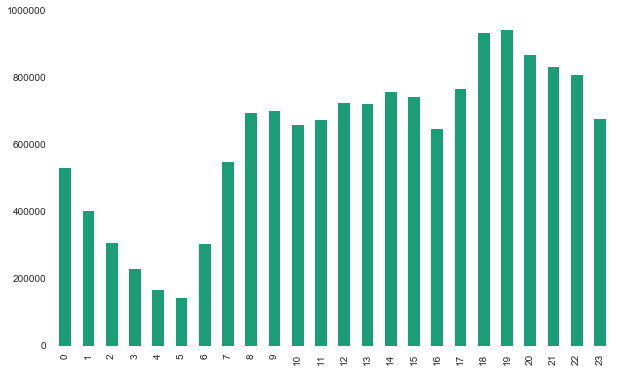

In [23]:
# By grouping by the pickup hour, and then plotting a histogram with 24 bins, we can look at the distribution of trips on an hourly basis.

trip_full_df.pickup_hour.groupby(trip_full_df.pickup_hour.values).size().plot(kind='bar')

In [24]:
%%time

# Adding a new column for the day of the week. I do this by first extracting the wday number and then mapping each day number 
# to a day of the week

trip_full_df['pickup_wday'] = trip_full_df['pickup_datetime'].apply(lambda x: time.strptime(x, "%Y-%m-%d %H:%M:%S").tm_wday)
trip_full_df['pickup_day'] = trip_full_df['pickup_wday'].map({0:'Monday', 1:'Tuesday',2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})

Wall time: 5min 22s


In order to look at the number of trips for each week day, I group by pickup_day column and then count the number of trips. It should be noted however that this bar chart does not give an accurate picture of the number of trips as a function of the day of the week, since in a given month some days might appear 4 times while some others appear 5 times.

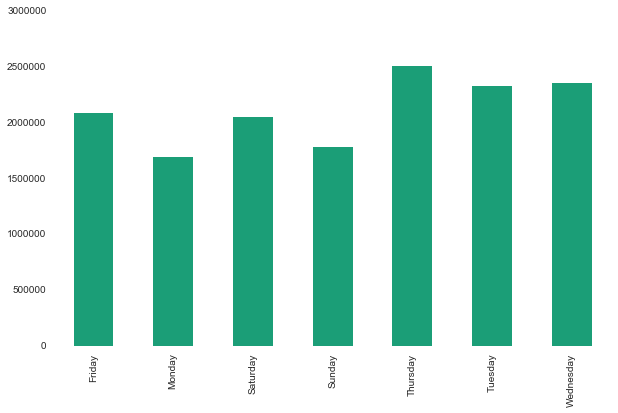

In [25]:
trip_full_df['pickup_day'].groupby(trip_full_df.pickup_day.values).size().plot(kind='bar')

In [26]:
%%time

# I extract the trip date from the pickup_datetime column and assign it to a new column
trip_full_df['full_date'] = trip_full_df['pickup_datetime'].apply(lambda x: x.split(" ")[0])

Wall time: 14.2 s


Wall time: 3min 54s


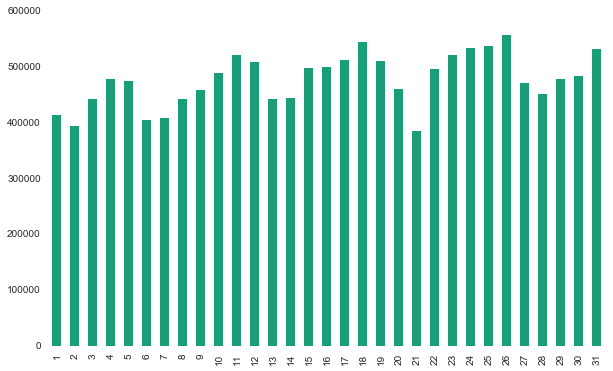

In [27]:
%%time

# I now introduce a new column for day of the month and look at the number of trips for each day.

trip_full_df['month_day'] = trip_full_df['pickup_datetime'].apply(lambda x: time.strptime(x, "%Y-%m-%d %H:%M:%S").tm_mday)
trip_full_df['month_day'].groupby(trip_full_df.month_day.values).size().plot(kind='bar')
# trip_pickup_date.groupby(trip_pickup_date).size().plot(kind='bar')

In [28]:
trip_full_df.head()

medallion                      hack_license  \
0  89D227B655E5C82AECF13C3F540D4CF4  BA96DE419E711691B9445D6A6307C170   
1  0BD7C8F5BA12B88E0B67BED28BEA73D8  9FD8F69F0804BDB5549F40E9DA1BE472   
2  0BD7C8F5BA12B88E0B67BED28BEA73D8  9FD8F69F0804BDB5549F40E9DA1BE472   
3  DFD2202EE08F7A8DC9A57B02ACB81FE2  51EE87E3205C985EF8431D850C786310   
4  DFD2202EE08F7A8DC9A57B02ACB81FE2  51EE87E3205C985EF8431D850C786310   

  vendor_id  rate_code store_and_fwd_flag      pickup_datetime  \
0       CMT          1                  N  2013-01-01 15:11:48   
1       CMT          1                  N  2013-01-06 00:18:35   
2       CMT          1                  N  2013-01-05 18:49:41   
3       CMT          1                  N  2013-01-07 23:54:15   
4       CMT          1                  N  2013-01-07 23:25:03   

      dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0  2013-01-01 15:18:10                4                382            1.0   
1  2013-01-06 00:22:54                1                259            1.5   
2  2013-01-05 18:54:23                1                282            1.1   
3  2013-01-07 23:58:20                2                244            0.7   
4  2013-01-07 23:34:24                1                560            2.1   

     ...      tip_amount  tolls_amount  total_amount  pickup_hour  \
0    ...             0.0           0.0           7.0           15   
1    ...             0.0           0.0           7.0            0   
2    ...             0.0           0.0           7.0           18   
3    ...             0.0           0.0           6.0           23   
4    ...             0.0           0.0          10.5           23   

  dropoff_hour  tip_fraction  pickup_wday  pickup_day   full_date  month_day  
0           15           0.0            1     Tuesday  2013-01-01          1  
1            0           0.0            6      Sunday  2013-01-06          6  
2           18           0.0            5    Saturday  2013-01-05          5  
3           23           0.0            0      Monday  2013-01-07          7  
4           23           0.0            0      Monday  2013-01-07          7  

[5 rows x 28 columns]

In [29]:
%%time

# Looking at the distribution of trips on a particular day. I choose Jan 21 since it had the least number of trips.
tripdata_jan21 = trip_full_df[trip_full_df.full_date == '2013-01-21']

Wall time: 12min 55s
Parser   : 136 ms


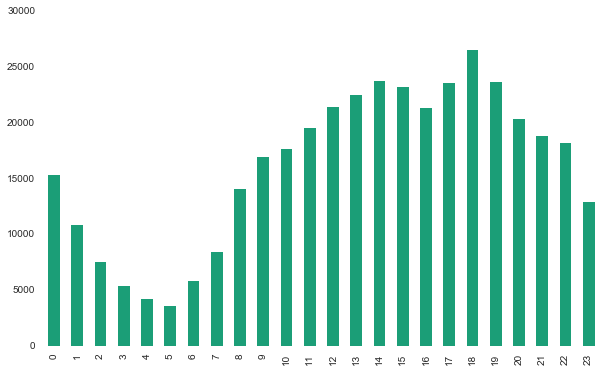

In [30]:
tripdata_jan21['pickup_hour'].groupby(tripdata_jan21['pickup_hour'].values).size().plot(kind='bar')

In [31]:
%%time

# Comparing trips on Jan 13 (Sunday) with Jan 16 (Wednesday)
tripdata_jan13 = trip_full_df[trip_full_df.full_date == '2013-01-13']
tripdata_jan16 = trip_full_df[trip_full_df.full_date == '2013-01-16']

Wall time: 3.67 s


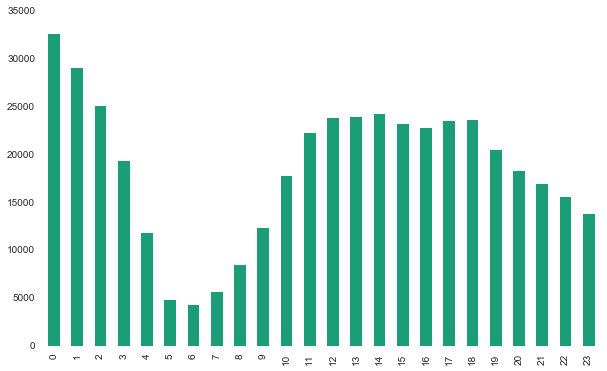

In [32]:
tripdata_jan13['pickup_hour'].groupby(tripdata_jan13['pickup_hour'].values).size().plot(kind='bar')

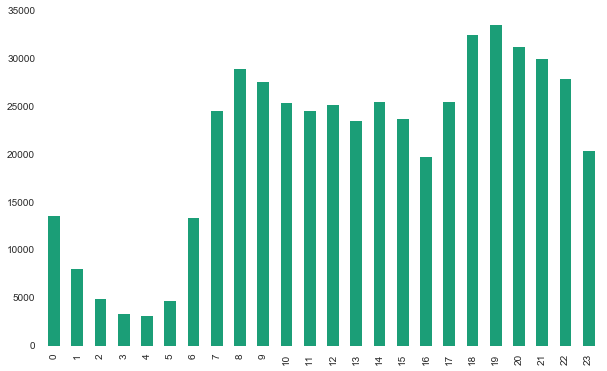

In [33]:
tripdata_jan16['pickup_hour'].groupby(tripdata_jan16['pickup_hour'].values).size().plot(kind='bar')

As we see, Jan 13 which is a Sunday has a very different pattern than Jan 16.

I also wanted to look at how many trips an individual driver typically partakes. In order to look at this, I looked at the distribution of the trips after grouping by the medallion number.

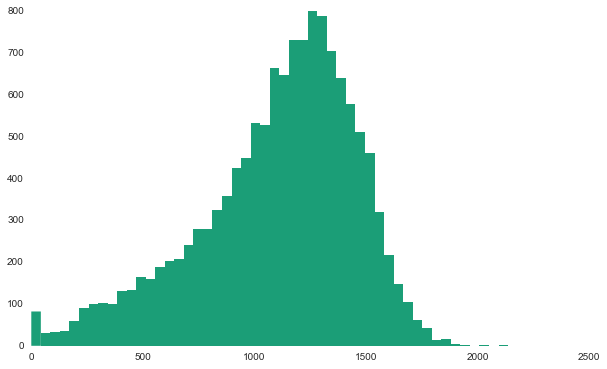

In [34]:
trip_full_df.groupby(['medallion']).size().hist(bins=50)

In [35]:
trip_full_df.describe()

C:\Users\Anirban\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


rate_code  passenger_count  trip_time_in_secs  trip_distance  \
count  1.477662e+07     1.477662e+07       1.477662e+07   1.477662e+07   
mean   1.034273e+00     1.697372e+00       6.834236e+02   2.770976e+00   
std    3.387715e-01     1.365396e+00       4.944063e+02   3.305923e+00   
min    0.000000e+00     0.000000e+00       0.000000e+00   0.000000e+00   
25%    1.000000e+00     1.000000e+00       3.600000e+02   1.000000e+00   
50%    1.000000e+00     1.000000e+00       5.540000e+02   1.700000e+00   
75%    1.000000e+00     2.000000e+00       8.850000e+02   3.060000e+00   
max    2.100000e+02     2.550000e+02       1.080000e+04   1.000000e+02   

       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count      1.477662e+07     1.477662e+07       1.477653e+07      1.477653e+07   
mean      -7.263634e+01     4.001440e+01      -7.259443e+01      3.999219e+01   
std        1.013819e+01     7.789904e+00       1.028860e+01      7.537067e+00   
min       -2.771285e+03    -3.547921e+03      -2.350956e+03     -3.547921e+03   
25%       -7.399188e+01     4.073551e+01                NaN               NaN   
50%       -7.398166e+01     4.075315e+01                NaN               NaN   
75%       -7.396684e+01     4.076729e+01                NaN               NaN   
max        1.124042e+02     3.310365e+03       2.228738e+03      3.477106e+03   

        fare_amount     surcharge       mta_tax    tip_amount  tolls_amount  \
count  1.477662e+07  1.477662e+07  1.477662e+07  1.477662e+07  1.477662e+07   
mean   1.166472e+01  3.204904e-01  4.983970e-01  1.267509e+00  2.018670e-01   
std    9.639219e+00  3.675741e-01  2.826541e-02  2.046084e+00  1.035481e+00   
min    2.500000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    6.500000e+00  0.000000e+00  5.000000e-01  0.000000e+00  0.000000e+00   
50%    9.000000e+00  0.000000e+00  5.000000e-01  8.000000e-01  0.000000e+00   
75%    1.300000e+01  5.000000e-01  5.000000e-01  2.000000e+00  0.000000e+00   
max    5.000000e+02  1.250000e+01  5.000000e-01  2.000000e+02  2.000000e+01   

       total_amount   pickup_hour  dropoff_hour  tip_fraction   pickup_wday  \
count  1.477662e+07  1.477662e+07  1.477662e+07  1.477662e+07  1.477662e+07   
mean   1.395298e+01  1.358165e+01  1.358404e+01  1.064043e-01  2.962503e+00   
std    1.146469e+01  6.401632e+00  6.461708e+00  1.652766e-01  1.895188e+00   
min    2.500000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    7.700000e+00  9.000000e+00  9.000000e+00  0.000000e+00  1.000000e+00   
50%    1.050000e+01  1.400000e+01  1.400000e+01  7.142857e-02  3.000000e+00   
75%    1.550000e+01  1.900000e+01  1.900000e+01  2.095238e-01  5.000000e+00   
max    6.500000e+02  2.300000e+01  2.300000e+01  7.880000e+01  6.000000e+00   

          month_day  
count  1.477662e+07  
mean   1.644678e+01  
std    8.838428e+00  
min    1.000000e+00  
25%    9.000000e+00  
50%    1.700000e+01  
75%    2.400000e+01  
max    3.100000e+01

Few things we notice. The minimum distance for a trip is 0. Any trip which has a distance of 0 should be filtered during analysis and modeling. Also, the latitude and longitude columns for dropoff have some NaN values. The latitude and longitude also have large numbers that make no sense (e.g the minimum value for pickup longitude is -2771).

In [36]:
%%time

trip_df_nonzero = trip_full_df[trip_full_df.trip_distance.astype(float) != 0]

Wall time: 6min 32s
Parser   : 138 ms


In [37]:
print trip_df_nonzero.shape
trip_df_nonzero.head()

(14693239, 28)


medallion                      hack_license  \
0  89D227B655E5C82AECF13C3F540D4CF4  BA96DE419E711691B9445D6A6307C170   
1  0BD7C8F5BA12B88E0B67BED28BEA73D8  9FD8F69F0804BDB5549F40E9DA1BE472   
2  0BD7C8F5BA12B88E0B67BED28BEA73D8  9FD8F69F0804BDB5549F40E9DA1BE472   
3  DFD2202EE08F7A8DC9A57B02ACB81FE2  51EE87E3205C985EF8431D850C786310   
4  DFD2202EE08F7A8DC9A57B02ACB81FE2  51EE87E3205C985EF8431D850C786310   

  vendor_id  rate_code store_and_fwd_flag      pickup_datetime  \
0       CMT          1                  N  2013-01-01 15:11:48   
1       CMT          1                  N  2013-01-06 00:18:35   
2       CMT          1                  N  2013-01-05 18:49:41   
3       CMT          1                  N  2013-01-07 23:54:15   
4       CMT          1                  N  2013-01-07 23:25:03   

      dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0  2013-01-01 15:18:10                4                382            1.0   
1  2013-01-06 00:22:54                1                259            1.5   
2  2013-01-05 18:54:23                1                282            1.1   
3  2013-01-07 23:58:20                2                244            0.7   
4  2013-01-07 23:34:24                1                560            2.1   

     ...      tip_amount  tolls_amount  total_amount  pickup_hour  \
0    ...             0.0           0.0           7.0           15   
1    ...             0.0           0.0           7.0            0   
2    ...             0.0           0.0           7.0           18   
3    ...             0.0           0.0           6.0           23   
4    ...             0.0           0.0          10.5           23   

  dropoff_hour  tip_fraction  pickup_wday  pickup_day   full_date  month_day  
0           15           0.0            1     Tuesday  2013-01-01          1  
1            0           0.0            6      Sunday  2013-01-06          6  
2           18           0.0            5    Saturday  2013-01-05          5  
3           23           0.0            0      Monday  2013-01-07          7  
4           23           0.0            0      Monday  2013-01-07          7  

[5 rows x 28 columns]

From a histogram of all latitude and longitude values (shown later as part of visualization), it was observed that most taxi trips take place between the latitudes of <b>40.7 and 40.8</b> and longitudes of <b>-74.05 and -73.8</b>

In [38]:
%%time

# Converting all location data to floats for easier analysis
trip_df_nonzero[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']] = \
trip_df_nonzero[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].astype(float)

# filtering the records belonging to relevant latitudes and longitudes
trips_with_location = trip_df_nonzero[(trip_df_nonzero.pickup_latitude >= 40.7) & \
                                                        (trip_df_nonzero.pickup_latitude <= 40.8) &\
                (trip_df_nonzero.pickup_longitude >= -74.05) & (trip_df_nonzero.pickup_longitude <= -73.8)]

C:\Users\Anirban\Anaconda2\lib\site-packages\pandas\core\frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Wall time: 10min 57s


In [39]:
print trips_with_location.shape
trips_with_location.head()

(13754630, 28)


medallion                      hack_license  \
0  89D227B655E5C82AECF13C3F540D4CF4  BA96DE419E711691B9445D6A6307C170   
1  0BD7C8F5BA12B88E0B67BED28BEA73D8  9FD8F69F0804BDB5549F40E9DA1BE472   
2  0BD7C8F5BA12B88E0B67BED28BEA73D8  9FD8F69F0804BDB5549F40E9DA1BE472   
3  DFD2202EE08F7A8DC9A57B02ACB81FE2  51EE87E3205C985EF8431D850C786310   
4  DFD2202EE08F7A8DC9A57B02ACB81FE2  51EE87E3205C985EF8431D850C786310   

  vendor_id  rate_code store_and_fwd_flag      pickup_datetime  \
0       CMT          1                  N  2013-01-01 15:11:48   
1       CMT          1                  N  2013-01-06 00:18:35   
2       CMT          1                  N  2013-01-05 18:49:41   
3       CMT          1                  N  2013-01-07 23:54:15   
4       CMT          1                  N  2013-01-07 23:25:03   

      dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0  2013-01-01 15:18:10                4                382            1.0   
1  2013-01-06 00:22:54                1                259            1.5   
2  2013-01-05 18:54:23                1                282            1.1   
3  2013-01-07 23:58:20                2                244            0.7   
4  2013-01-07 23:34:24                1                560            2.1   

     ...      tip_amount  tolls_amount  total_amount  pickup_hour  \
0    ...             0.0           0.0           7.0           15   
1    ...             0.0           0.0           7.0            0   
2    ...             0.0           0.0           7.0           18   
3    ...             0.0           0.0           6.0           23   
4    ...             0.0           0.0          10.5           23   

  dropoff_hour  tip_fraction  pickup_wday  pickup_day   full_date  month_day  
0           15           0.0            1     Tuesday  2013-01-01          1  
1            0           0.0            6      Sunday  2013-01-06          6  
2           18           0.0            5    Saturday  2013-01-05          5  
3           23           0.0            0      Monday  2013-01-07          7  
4           23           0.0            0      Monday  2013-01-07          7  

[5 rows x 28 columns]

### Data Munging and analysis with a subset

We extract a sample from the overall dataset. Later, we will perform some feature engineering on this subset as an experimental step before running the feature engineering algorithm on the entire dataset.
Additionally, from this sample, we filter only those trips that are within those latitudes and longitudes where a large number of taxi trips take place.

<b>The sample data has been stored in a separate file so that the sampling code does not have to be run each time.</b>

In [40]:
%%time

sample_trips_with_location = trips_with_location.sample(n=500000, random_state=1)

Wall time: 25min 1s
Parser   : 679 ms


In [41]:
sample_trips_with_location.head()

medallion                      hack_license  \
10398690  F47E83A52C8401C874B99A98CCE246DF  4E260C3310346E735CBDF8C8E6761D66   
7409709   3AA58DEEC2CA4C104FCA781EC38B6DA1  8F986F92BDA7196564FAA2766EFCD3AD   
10837498  BEEB829C76993A19098AFA1F5C0C88D2  1C3DFBBA24C7057BF7CB1E48E28153F0   
5156833   3E7AA144EBE43CE6B567524550C78DFF  4AEEA5836012EA84DF0E246D002E1A41   
9110142   A5C6F0FC150417517C2894400795B1F8  97336339EBD6E99950B8D11E083E932B   

         vendor_id  rate_code store_and_fwd_flag      pickup_datetime  \
10398690       VTS          1                NaN  2013-01-30 16:34:00   
7409709        CMT          1                  N  2013-01-16 22:31:15   
10837498       CMT          1                  N  2013-01-28 14:34:48   
5156833        VTS          1                NaN  2013-01-18 18:43:00   
9110142        VTS          1                NaN  2013-01-22 00:21:00   

             dropoff_datetime  passenger_count  trip_time_in_secs  \
10398690  2013-01-30 16:43:00                1                540   
7409709   2013-01-16 22:37:24                1                368   
10837498  2013-01-28 14:47:36                1                767   
5156833   2013-01-18 18:50:00                5                420   
9110142   2013-01-22 00:37:00                1                960   

          trip_distance    ...      tip_amount  tolls_amount  total_amount  \
10398690           0.86    ...             0.0           0.0           7.5   
7409709            1.20    ...             0.0           0.0           7.5   
10837498           1.90    ...             2.2           0.0          13.2   
5156833            1.22    ...             1.6           0.0          10.1   
9110142            6.94    ...             0.0           0.0          22.0   

          pickup_hour dropoff_hour  tip_fraction  pickup_wday  pickup_day  \
10398690           16           16      0.000000            2   Wednesday   
7409709            22           22      0.000000            2   Wednesday   
10837498           14           14      0.209524            0      Monday   
5156833            18           18      0.228571            4      Friday   
9110142             0            0      0.000000            1     Tuesday   

           full_date  month_day  
10398690  2013-01-30         30  
7409709   2013-01-16         16  
10837498  2013-01-28         28  
5156833   2013-01-18         18  
9110142   2013-01-22         22  

[5 rows x 28 columns]

In order to make sure that the sample data is fairly representative of the overall dataset, I looked at the trip count distribution for each one-hour slot.

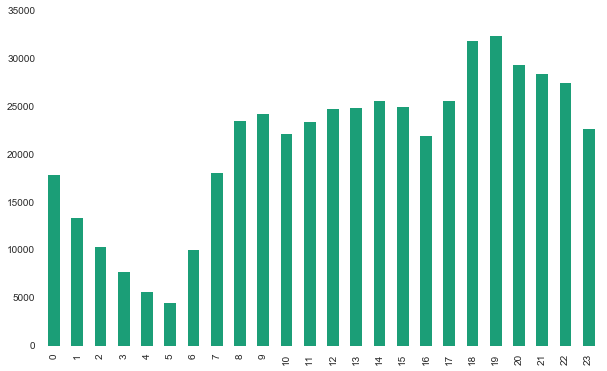

In [42]:
sample_trips_with_location['pickup_hour'].groupby(sample_trips_with_location['pickup_hour'].values).size().plot(kind='bar')

In [43]:
%%time

sample_trips_with_location.to_csv('../nyc_taxi_files/2013_Jan_samples.csv',index=False)

Wall time: 17.1 s


In [44]:
%%time

sample_trips_with_location = pd.read_csv('../nyc_taxi_files/2013_Jan_samples.csv')

Wall time: 10.4 s


In [45]:
sample_trips_with_location.head()

medallion                      hack_license  \
0  F47E83A52C8401C874B99A98CCE246DF  4E260C3310346E735CBDF8C8E6761D66   
1  3AA58DEEC2CA4C104FCA781EC38B6DA1  8F986F92BDA7196564FAA2766EFCD3AD   
2  BEEB829C76993A19098AFA1F5C0C88D2  1C3DFBBA24C7057BF7CB1E48E28153F0   
3  3E7AA144EBE43CE6B567524550C78DFF  4AEEA5836012EA84DF0E246D002E1A41   
4  A5C6F0FC150417517C2894400795B1F8  97336339EBD6E99950B8D11E083E932B   

  vendor_id  rate_code store_and_fwd_flag      pickup_datetime  \
0       VTS          1                NaN  2013-01-30 16:34:00   
1       CMT          1                  N  2013-01-16 22:31:15   
2       CMT          1                  N  2013-01-28 14:34:48   
3       VTS          1                NaN  2013-01-18 18:43:00   
4       VTS          1                NaN  2013-01-22 00:21:00   

      dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0  2013-01-30 16:43:00                1                540           0.86   
1  2013-01-16 22:37:24                1                368           1.20   
2  2013-01-28 14:47:36                1                767           1.90   
3  2013-01-18 18:50:00                5                420           1.22   
4  2013-01-22 00:37:00                1                960           6.94   

     ...      tip_amount  tolls_amount  total_amount  pickup_hour  \
0    ...             0.0           0.0           7.5           16   
1    ...             0.0           0.0           7.5           22   
2    ...             2.2           0.0          13.2           14   
3    ...             1.6           0.0          10.1           18   
4    ...             0.0           0.0          22.0            0   

  dropoff_hour  tip_fraction  pickup_wday  pickup_day   full_date  month_day  
0           16      0.000000            2   Wednesday  2013-01-30         30  
1           22      0.000000            2   Wednesday  2013-01-16         16  
2           14      0.209524            0      Monday  2013-01-28         28  
3           18      0.228571            4      Friday  2013-01-18         18  
4            0      0.000000            1     Tuesday  2013-01-22         22  

[5 rows x 28 columns]

In [46]:
sample_trips_with_location.shape

(500000, 28)

### Neighborhoods Data

We read in the neighborhood dataset available in Open NYC Data and extract the latitude and longitude values of each. We will later use this dataset to add another column in the taxi data.

In [47]:
%%time

neighborhood_df = pd.read_csv('https://data.cityofnewyork.us/api/views/xyye-rtrs/rows.csv')

Wall time: 1min 4s


In [48]:
neighborhood_df.tail()

the_geom  OBJECTID             Name  \
294  POINT (-74.13792663771576 40.576506293794935)       295  Lighthouse Hill   
295  POINT (-74.22957080626948 40.519541457489126)       296  Richmond Valley   
296   POINT (-73.8266775713865 40.790601556701525)       297            Malba   
297    POINT (-73.8902809854761 40.68248551101694)       298    Highland Park   
298    POINT (-73.948415153289 40.609377701137696)       299          Madison   

     Stacked   AnnoLine1 AnnoLine2 AnnoLine3  AnnoAngle        Borough  
294        2  Lighthouse      Hill       NaN          0  Staten Island  
295        2    Richmond    Valley       NaN          0  Staten Island  
296        1       Malba       NaN       NaN          0         Queens  
297        2    Highland      Park       NaN          0       Brooklyn  
298        1     Madison       NaN       NaN          0       Brooklyn

I extract the latitude and longitude information from the <b> 'the_geom' </b> parameter in the neighborhood dataset. These values are stored in two new columns.

In [49]:
%%time

neighborhood_df['longitude']=neighborhood_df['the_geom'].apply(lambda x: (x[7: -1]).split(' ')[0])
neighborhood_df['latitude']=neighborhood_df['the_geom'].apply(lambda x: (x[7: -1]).split(' ')[1])

Wall time: 120 ms


In [50]:
# Change the datatype of the latitude and longitude columns to float

neighborhood_df['longitude'] = neighborhood_df['longitude'].astype(float)
neighborhood_df['latitude'] = neighborhood_df['latitude'].astype(float)

In [51]:
neighborhood_df.head()

the_geom  OBJECTID         Name  \
0    POINT (-73.8472005205491 40.89470517661004)         1    Wakefield   
1   POINT (-73.82993910812405 40.87429419303015)         2   Co-op City   
2   POINT (-73.82780644716419 40.88755567735082)         3  Eastchester   
3  POINT (-73.90564259591689 40.895437426903875)         4    Fieldston   
4   POINT (-73.91258546108577 40.89083449389134)         5    Riverdale   

   Stacked    AnnoLine1 AnnoLine2 AnnoLine3  AnnoAngle Borough  longitude  \
0        1    Wakefield       NaN       NaN          0   Bronx -73.847201   
1        2        Co-op      City       NaN          0   Bronx -73.829939   
2        1  Eastchester       NaN       NaN          0   Bronx -73.827806   
3        1    Fieldston       NaN       NaN          0   Bronx -73.905643   
4        1    Riverdale       NaN       NaN          0   Bronx -73.912585   

    latitude  
0  40.894705  
1  40.874294  
2  40.887556  
3  40.895437  
4  40.890834

### Inserting neighborhood details within a sample of the data

I continue working with the sample dataset extracted from the overall dataset earlier. I now combine this sample dataset with the neighborhoods data so that each trip is assigned a neighborhood.

Seen below are the various neighborhoods from the dataset. In order to assign a particular neighborhood to each taxi trip, we would have to iterate through all the neighborhoods to find which one is the closest to a particular pickup point.

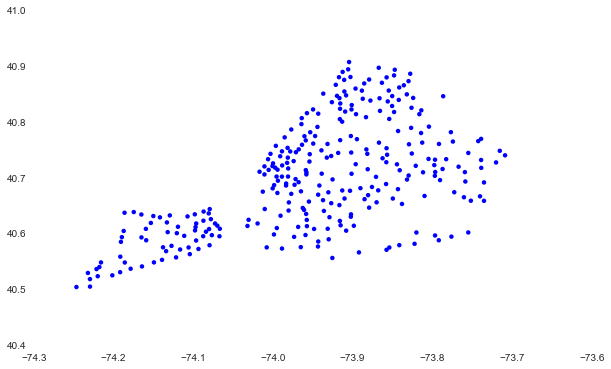

In [52]:
plt.scatter(x = neighborhood_df['longitude'], y = neighborhood_df['latitude'])

### K-means clustering on the neighborhoods dataset.

Instead of iterating through the entire neighborhood dataset while trying to assign a neighborhood to each taxi trip, we can instead use K-means clustering to split the dataset into 5 clusters. Subsequently, we can determine the cluster to which each of the pickup point from the taxi trip dataset belongs to, and then search only within that cluster for the exact neighborhood. This way, we can reduce the processing time by almost a factor of 5.

A possible downside for this approach is that it is possible that we have a cluster centroid lying close to the pickup latitude and longitude but the actual neighborhood closest to the pickup point lies at the border of a different cluster. For now, we ignore these border cases.

In [53]:
centroids = []
cls = cluster.k_means(neighborhood_df[['longitude', 'latitude']].values, 5)
centroids.append(cls[0])
neighborhood_df['clusters'] = cls[1] # A new column is added to the neighborhoods dataset

print cls

(array([[-73.93652291,  40.62402866],
       [-73.79772289,  40.70843049],
       [-74.13890585,  40.58839034],
       [-73.96713601,  40.72986982],
       [-73.87915333,  40.84291032]]), array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 0, 0, 1, 0,
       0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1,
       1, 1, 1, 3, 3, 4, 3, 3, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 4, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [54]:
neighborhood_df.tail()

the_geom  OBJECTID             Name  \
294  POINT (-74.13792663771576 40.576506293794935)       295  Lighthouse Hill   
295  POINT (-74.22957080626948 40.519541457489126)       296  Richmond Valley   
296   POINT (-73.8266775713865 40.790601556701525)       297            Malba   
297    POINT (-73.8902809854761 40.68248551101694)       298    Highland Park   
298    POINT (-73.948415153289 40.609377701137696)       299          Madison   

     Stacked   AnnoLine1 AnnoLine2 AnnoLine3  AnnoAngle        Borough  \
294        2  Lighthouse      Hill       NaN          0  Staten Island   
295        2    Richmond    Valley       NaN          0  Staten Island   
296        1       Malba       NaN       NaN          0         Queens   
297        2    Highland      Park       NaN          0       Brooklyn   
298        1     Madison       NaN       NaN          0       Brooklyn   

     longitude   latitude  clusters  
294 -74.137927  40.576506         2  
295 -74.229571  40.519541         2  
296 -73.826678  40.790602         4  
297 -73.890281  40.682486         0  
298 -73.948415  40.609378         0

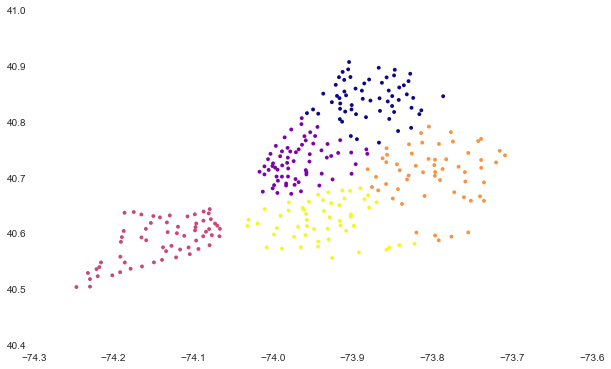

In [55]:
plt.scatter(x = neighborhood_df['longitude'], y = neighborhood_df['latitude'], c=neighborhood_df['clusters'], s=15, cmap='plasma_r')

I wanted to check if there are some neighborhoods that share their names with others i.e. whether we have more than 1 neighborhoods with the same names.

In [56]:
neighborhood_df_sorted = neighborhood_df.sort('Name')

C:\Users\Anirban\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [57]:
neighborhood_df_sorted.head()

the_geom  OBJECTID           Name  \
217  POINT (-74.17854866165885 40.538114174745104)       218       Annadale   
243    POINT (-74.185886745839 40.549285822783254)       244  Arden Heights   
229   POINT (-74.16510420241131 40.63532509911496)       230      Arlington   
230  POINT (-74.06712363225581 40.596312571276776)       231       Arrochar   
179    POINT (-73.7919923313695 40.58914394372975)       180        Arverne   

     Stacked  AnnoLine1 AnnoLine2 AnnoLine3  AnnoAngle        Borough  \
217        1   Annadale       NaN       NaN          0  Staten Island   
243        2      Arden   Heights       NaN          0  Staten Island   
229        1  Arlington       NaN       NaN          0  Staten Island   
230        1   Arrochar       NaN       NaN          0  Staten Island   
179        1    Arverne       NaN       NaN          0         Queens   

     longitude   latitude  clusters  
217 -74.178549  40.538114         2  
243 -74.185887  40.549286         2  
229 -74.165104  40.635325         2  
230 -74.067124  40.596313         2  
179 -73.791992  40.589144         1

In [58]:
neighborhood_df_sorted.reset_index(drop=True, inplace = True)

In [59]:
neighborhood_df_sorted.head()

the_geom  OBJECTID           Name  \
0  POINT (-74.17854866165885 40.538114174745104)       218       Annadale   
1    POINT (-74.185886745839 40.549285822783254)       244  Arden Heights   
2   POINT (-74.16510420241131 40.63532509911496)       230      Arlington   
3  POINT (-74.06712363225581 40.596312571276776)       231       Arrochar   
4    POINT (-73.7919923313695 40.58914394372975)       180        Arverne   

   Stacked  AnnoLine1 AnnoLine2 AnnoLine3  AnnoAngle        Borough  \
0        1   Annadale       NaN       NaN          0  Staten Island   
1        2      Arden   Heights       NaN          0  Staten Island   
2        1  Arlington       NaN       NaN          0  Staten Island   
3        1   Arrochar       NaN       NaN          0  Staten Island   
4        1    Arverne       NaN       NaN          0         Queens   

   longitude   latitude  clusters  
0 -74.178549  40.538114         2  
1 -74.185887  40.549286         2  
2 -74.165104  40.635325         2  
3 -74.067124  40.596313         2  
4 -73.791992  40.589144         1

In [60]:
neighborhood_grouped = neighborhood_df_sorted.groupby('Name').count()[['Borough']]
neighborhood_grouped[neighborhood_grouped.Borough > 1]

Borough
Name                
Bay Terrace        2
Chelsea            2
Murray Hill        2
Sunnyside          2

4 of the neighborhoods appear in 2 different boroughs. Let's take a look at these. 

In [61]:
neighborhood_df[neighborhood_df.Name.isin(['Bay Terrace','Chelsea','Murray Hill','Sunnyside'])]

the_geom  OBJECTID         Name  \
117   POINT (-73.97833207924134 40.74830307725222)       118  Murray Hill   
118    POINT (-74.0031163347282 40.74403470674802)       119      Chelsea   
142   POINT (-73.92691617561584 40.74017628351928)       143    Sunnyside   
177    POINT (-73.77680222621588 40.7828428062456)       178  Bay Terrace   
182    POINT (-73.81276269135873 40.7641261226141)       183  Murray Hill   
222  POINT (-74.09712552178537 40.612760157564935)       223    Sunnyside   
237   POINT (-74.13916622175775 40.55398800858466)       238  Bay Terrace   
246   POINT (-74.18956045519697 40.59472602746298)       247      Chelsea   

     Stacked  AnnoLine1 AnnoLine2 AnnoLine3  AnnoAngle        Borough  \
117        2     Murray      Hill       NaN          0      Manhattan   
118        1    Chelsea       NaN       NaN          0      Manhattan   
142        1  Sunnyside       NaN       NaN          0         Queens   
177        2        Bay   Terrace       NaN          0         Queens   
182        2     Murray      Hill       NaN          0         Queens   
222        1  Sunnyside       NaN       NaN          0  Staten Island   
237        2        Bay   Terrace       NaN          0  Staten Island   
246        1    Chelsea       NaN       NaN          0  Staten Island   

     longitude   latitude  clusters  
117 -73.978332  40.748303         3  
118 -74.003116  40.744035         3  
142 -73.926916  40.740176         3  
177 -73.776802  40.782843         1  
182 -73.812763  40.764126         1  
222 -74.097126  40.612760         2  
237 -74.139166  40.553988         2  
246 -74.189560  40.594726         2

As we see, Murray Hill belongs to Manhattan as well as Queens, Chelsea belongs to Manhattan as well as Staten Island, and so on. These will be handled later on after we add the neighborhoods data to the trip data.

A Dataframe with information on the centroids is defined below. This will be used to find out which centroid lies nearest to a given pickup point. Only neighborhoods of that particular cluster will be searched when determining the neighborhood of a pickup point.

In [62]:
centroids_df = pd.DataFrame(data=centroids[0], columns=('centroid_lon','centroid_lat'))
centroids_df['cluster'] = centroids_df.index.astype(int)

In [63]:
centroids_df

centroid_lon  centroid_lat  cluster
0    -73.936523     40.624029        0
1    -73.797723     40.708430        1
2    -74.138906     40.588390        2
3    -73.967136     40.729870        3
4    -73.879153     40.842910        4

The following method takes as argument the latitude and longitude information and the cluster index. It returns the neighborhood from the specified cluster and is closest to the given latitude and longitude.

In [64]:
def search_cluster(lat,lon,cluster_ind):
    '''
    Determines the New York neighborhood that is most likely to contain a location identified from its latitude and longitude.
    Args:
        lat (float): Latitude of the required location.
        lon (float): Longitude of the required location.
        cluster_ind (int): Index of the cluster of neighborhoods within which the location lies. 
                            There are a total of 5 clusters into which all the neighborhoods have been classified.
    Returns:
        neighborhood_name (str): Name of the neighborhood that is most likely to contain the given location.
        
    '''
    cluster_df = neighborhood_df[neighborhood_df['clusters'] == cluster_ind]

    dist_array = {}
    
    
    for index2, neighborhood in cluster_df.iterrows():
        miles = np.sqrt((lat - neighborhood['latitude'])**2 + (lon - neighborhood['longitude'])**2)
        
        dist_array[miles] = neighborhood['Name']   
    
    return dist_array[min(dist_array)]

Here, I iterate through all the rows in the sample trip dataset and determine which cluster it belongs to. I then call the method `search_cluster` to determine which neighborhood the pickup point belongs to.

The result is stored as an array of neighborhood names.

Note that this code block takes <b>more than 1 hour to execute</b>. If you don't want to execute this, you can move on and instead pull the new modified dataset that already contains the neighborhood data and has been saved.

In [65]:
%%time


neighborhood_array=[]
for index1, taxi_row in sample_trips_with_location.iterrows():
    
    dist_min = 100
    cluster_ind = 6
    
    for index2, centroid in centroids_df.iterrows():
        dist = np.sqrt((taxi_row['pickup_latitude'] - centroid['centroid_lat'])**2 + (taxi_row['pickup_longitude'] - centroid['centroid_lon'])**2)

        if dist < dist_min:
            dist_min = dist
            cluster_ind = centroid['cluster'].astype(int)
        
    nearest_nbrhd = search_cluster(taxi_row['pickup_latitude'],taxi_row['pickup_longitude'],cluster_ind)
    neighborhood_array.append(nearest_nbrhd)

Wall time: 1h 13min 8s


In [66]:
print neighborhood_array[0:5]
len(neighborhood_array)

['Midtown', 'Noho', 'Clinton', 'Midtown', 'Clinton']


500000

I insert the neighborhood array into a new column of the trip sample data.

In [67]:
sample_trips_with_location['neighborhood'] = neighborhood_array

In [68]:
sample_trips_with_location.shape

(500000, 29)

In [69]:
sample_trips_with_location.head()

medallion                      hack_license  \
0  F47E83A52C8401C874B99A98CCE246DF  4E260C3310346E735CBDF8C8E6761D66   
1  3AA58DEEC2CA4C104FCA781EC38B6DA1  8F986F92BDA7196564FAA2766EFCD3AD   
2  BEEB829C76993A19098AFA1F5C0C88D2  1C3DFBBA24C7057BF7CB1E48E28153F0   
3  3E7AA144EBE43CE6B567524550C78DFF  4AEEA5836012EA84DF0E246D002E1A41   
4  A5C6F0FC150417517C2894400795B1F8  97336339EBD6E99950B8D11E083E932B   

  vendor_id  rate_code store_and_fwd_flag      pickup_datetime  \
0       VTS          1                NaN  2013-01-30 16:34:00   
1       CMT          1                  N  2013-01-16 22:31:15   
2       CMT          1                  N  2013-01-28 14:34:48   
3       VTS          1                NaN  2013-01-18 18:43:00   
4       VTS          1                NaN  2013-01-22 00:21:00   

      dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0  2013-01-30 16:43:00                1                540           0.86   
1  2013-01-16 22:37:24                1                368           1.20   
2  2013-01-28 14:47:36                1                767           1.90   
3  2013-01-18 18:50:00                5                420           1.22   
4  2013-01-22 00:37:00                1                960           6.94   

       ...       tolls_amount  total_amount  pickup_hour  dropoff_hour  \
0      ...                0.0           7.5           16            16   
1      ...                0.0           7.5           22            22   
2      ...                0.0          13.2           14            14   
3      ...                0.0          10.1           18            18   
4      ...                0.0          22.0            0             0   

  tip_fraction  pickup_wday  pickup_day   full_date  month_day  neighborhood  
0     0.000000            2   Wednesday  2013-01-30         30       Midtown  
1     0.000000            2   Wednesday  2013-01-16         16          Noho  
2     0.209524            0      Monday  2013-01-28         28       Clinton  
3     0.228571            4      Friday  2013-01-18         18       Midtown  
4     0.000000            1     Tuesday  2013-01-22         22       Clinton  

[5 rows x 29 columns]

This dataframe with the neighborhood data is saved in a csv and can be pulled later. This ensures that the cluster search does not have to be executed each time we need this dataset.

In [70]:
%%time

sample_trips_with_location.to_csv('../nyc_taxi_files/2013_Jan_sample_neighborhood.csv',index=False)

Wall time: 13.4 s


In [71]:
%%time

sample_trips_with_location = pd.read_csv('../nyc_taxi_files/2013_Jan_sample_neighborhood.csv')

Wall time: 6.15 s


In [72]:
sample_trips_with_location.head()

medallion                      hack_license  \
0  F47E83A52C8401C874B99A98CCE246DF  4E260C3310346E735CBDF8C8E6761D66   
1  3AA58DEEC2CA4C104FCA781EC38B6DA1  8F986F92BDA7196564FAA2766EFCD3AD   
2  BEEB829C76993A19098AFA1F5C0C88D2  1C3DFBBA24C7057BF7CB1E48E28153F0   
3  3E7AA144EBE43CE6B567524550C78DFF  4AEEA5836012EA84DF0E246D002E1A41   
4  A5C6F0FC150417517C2894400795B1F8  97336339EBD6E99950B8D11E083E932B   

  vendor_id  rate_code store_and_fwd_flag      pickup_datetime  \
0       VTS          1                NaN  2013-01-30 16:34:00   
1       CMT          1                  N  2013-01-16 22:31:15   
2       CMT          1                  N  2013-01-28 14:34:48   
3       VTS          1                NaN  2013-01-18 18:43:00   
4       VTS          1                NaN  2013-01-22 00:21:00   

      dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0  2013-01-30 16:43:00                1                540           0.86   
1  2013-01-16 22:37:24                1                368           1.20   
2  2013-01-28 14:47:36                1                767           1.90   
3  2013-01-18 18:50:00                5                420           1.22   
4  2013-01-22 00:37:00                1                960           6.94   

       ...       tolls_amount  total_amount  pickup_hour  dropoff_hour  \
0      ...                0.0           7.5           16            16   
1      ...                0.0           7.5           22            22   
2      ...                0.0          13.2           14            14   
3      ...                0.0          10.1           18            18   
4      ...                0.0          22.0            0             0   

  tip_fraction  pickup_wday  pickup_day   full_date  month_day  neighborhood  
0     0.000000            2   Wednesday  2013-01-30         30       Midtown  
1     0.000000            2   Wednesday  2013-01-16         16          Noho  
2     0.209524            0      Monday  2013-01-28         28       Clinton  
3     0.228571            4      Friday  2013-01-18         18       Midtown  
4     0.000000            1     Tuesday  2013-01-22         22       Clinton  

[5 rows x 29 columns]

I now proceed to look at the number of trips on a particular day in a given neighborhood and in a 1-hour slot. For this, we need to group by ['full_date','pickup_hour','neighborhood'].

In [73]:
sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood']).count()

medallion  hack_license  vendor_id  \
full_date  pickup_hour neighborhood                                             
2013-01-01 0           Astoria                     2             2          2   
                       Battery Park City           6             6          6   
                       Bushwick                    1             1          1   
                       Carnegie Hill              31            31         31   
                       Central Harlem              1             1          1   
                       Chelsea                    64            64         64   
                       Chinatown                  11            11         11   
                       Civic Center               25            25         25   
                       Clinton                    54            54         54   
                       Dumbo                       1             1          1   
                       East Elmhurst               2             2          2   
                       East Harlem                 7             7          7   
                       East Village               37            37         37   
                       East Williamsburg           7             7          7   
                       Financial District         21            21         21   
                       Flatiron                   55            55         55   
                       Gramercy                   39            39         39   
                       Greenpoint                  2             2          2   
                       Greenwich Village          31            31         31   
                       Hunters Point               2             2          2   
                       Lenox Hill                 33            33         33   
                       Lincoln Square             73            73         73   
                       Little Italy               11            11         11   
                       Long Island City            4             4          4   
                       Lower East Side             6             6          6   
                       Manhattan Valley           14            14         14   
                       Midtown                    56            56         56   
                       Midtown South              61            61         61   
                       Murray Hill                37            37         37   
                       Noho                       35            35         35   
...                                              ...           ...        ...   
2013-01-31 23          Flatiron                   53            53         53   
                       Fulton Ferry                1             1          1   
                       Gramercy                   35            35         35   
                       Greenwich Village          47            47         47   
                       Hunters Point               2             2          2   
                       Lenox Hill                 16            16         16   
                       Lincoln Square             93            93         93   
                       Little Italy               20            20         20   
                       Long Island City            3             3          3   
                       Lower East Side             2             2          2   
                       Manhattan Valley           13            13         13   
                       Midtown                   120           120        120   
                       Midtown South              65            65         65   
                       Murray Hill                39            39         39   
                       Noho                       43            43         43   
                       North Side                 14            14         14   
                       Ravenswood                  1             1        

I define a new dataframe that contains the date, pickup hour, pickup day, neighborhood, number of trips, and month day.

In [74]:
trip_count_df = pd.DataFrame(columns = ['full_date','pickup_hour','pickup_day','neighborhood','month_day','no_of_trips'])

In [75]:
%%time

# All columns except the number of trips are assigned using the .first() corresponding to that column in a particular group
trip_count_df['full_date'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['full_date'].first().values
trip_count_df['pickup_hour'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['pickup_hour'].first().values
trip_count_df['neighborhood'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['neighborhood'].first().values
trip_count_df['pickup_day'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['pickup_day'].first().values
trip_count_df['month_day'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['month_day'].first().values

# The number of trips is determined using the .count() method
trip_count_df['no_of_trips'] = sample_trips_with_location.groupby(['full_date','pickup_hour','neighborhood'])['neighborhood'].count().values

Wall time: 1.25 s


In [76]:
trip_count_df.head()

full_date  pickup_hour pickup_day       neighborhood  month_day  \
0  2013-01-01            0    Tuesday            Astoria          1   
1  2013-01-01            0    Tuesday  Battery Park City          1   
2  2013-01-01            0    Tuesday           Bushwick          1   
3  2013-01-01            0    Tuesday      Carnegie Hill          1   
4  2013-01-01            0    Tuesday     Central Harlem          1   

   no_of_trips  
0            2  
1            6  
2            1  
3           31  
4            1

In [77]:
trip_count_df.shape

(29553, 6)

In [78]:
print trip_count_df['neighborhood'].unique().size
print neighborhood_df['Name'].unique().size

82
295


I remove the data corresponding to 'Bay Terrace','Chelsea','Murray Hill', and 'Sunnyside' neighborhoods. These are the neighborhoods that appear more than once.

In [79]:
%%time

trip_count_df = trip_count_df[~(trip_count_df.neighborhood.isin(['Bay Terrace','Chelsea','Murray Hill','Sunnyside']))]

Wall time: 82 ms


In [80]:
trip_count_df.shape

(27790, 6)

In order to include the details of the neighborhood data such as latitude, longitude, and Borough that it belongs to by joining the trip_count_df dataframe with the neighborhood_df dataframe.

In [91]:
%%time

trip_count_with_neighborhood = trip_count_df.set_index('neighborhood').join(neighborhood_df.set_index('Name'))

Wall time: 31 ms


In [82]:
trip_count_with_neighborhood.shape

(27790, 16)

In [83]:
trip_count_with_neighborhood.head()

full_date  pickup_hour pickup_day  month_day  no_of_trips  \
Astoria  2013-01-01            0    Tuesday          1            2   
Astoria  2013-01-01            1    Tuesday          1            6   
Astoria  2013-01-01            2    Tuesday          1            7   
Astoria  2013-01-01            3    Tuesday          1           10   
Astoria  2013-01-01            4    Tuesday          1            7   

                                              the_geom  OBJECTID  Stacked  \
Astoria  POINT (-73.91565374304241 40.768508593354966)       132        1   
Astoria  POINT (-73.91565374304241 40.768508593354966)       132        1   
Astoria  POINT (-73.91565374304241 40.768508593354966)       132        1   
Astoria  POINT (-73.91565374304241 40.768508593354966)       132        1   
Astoria  POINT (-73.91565374304241 40.768508593354966)       132        1   

        AnnoLine1 AnnoLine2 AnnoLine3  AnnoAngle Borough  longitude  \
Astoria   Astoria       NaN       NaN          0  Queens -73.915654   
Astoria   Astoria       NaN       NaN          0  Queens -73.915654   
Astoria   Astoria       NaN       NaN          0  Queens -73.915654   
Astoria   Astoria       NaN       NaN          0  Queens -73.915654   
Astoria   Astoria       NaN       NaN          0  Queens -73.915654   

          latitude  clusters  
Astoria  40.768509         3  
Astoria  40.768509         3  
Astoria  40.768509         3  
Astoria  40.768509         3  
Astoria  40.768509         3

I want to retain only some of the important columns of this dataset. This columns are extracted as shown below.

In [92]:
%%time

trip_count_with_neighborhood = trip_count_with_neighborhood[['full_date','pickup_hour','pickup_day','month_day','Borough','longitude','latitude','no_of_trips']]
trip_count_with_neighborhood['neighborhood'] = trip_count_with_neighborhood.index.values
trip_count_with_neighborhood.reset_index(drop=True,inplace=True)

Wall time: 156 ms


In [93]:
trip_count_with_neighborhood.head()

full_date  pickup_hour pickup_day  month_day Borough  longitude  \
0  2013-01-01            0    Tuesday          1  Queens -73.915654   
1  2013-01-01            1    Tuesday          1  Queens -73.915654   
2  2013-01-01            2    Tuesday          1  Queens -73.915654   
3  2013-01-01            3    Tuesday          1  Queens -73.915654   
4  2013-01-01            4    Tuesday          1  Queens -73.915654   

    latitude  no_of_trips neighborhood  
0  40.768509            2      Astoria  
1  40.768509            6      Astoria  
2  40.768509            7      Astoria  
3  40.768509           10      Astoria  
4  40.768509            7      Astoria

In [94]:
trip_count_with_neighborhood.shape

(27790, 9)

In [95]:
print trip_count_with_neighborhood.Borough.unique()
print trip_count_with_neighborhood.neighborhood.unique().size

['Queens' 'Manhattan' 'Brooklyn' 'Bronx']
79


In [96]:
%%time

trip_count_with_neighborhood.to_csv('../nyc_taxi_files/2013_Jan_sample_tripcount.csv',index = False)

Wall time: 229 ms


### Linear Regression models

I use statsmodels and scikit-learn in order to build a predictive model for the no of taxi trips in a given neighborhood for a given 1 hour time period.

In [97]:
%%time

trip_count_with_neighborhood = pd.read_csv('../nyc_taxi_files/2013_Jan_sample_tripcount.csv')

Wall time: 65 ms


In [98]:
trip_count_with_neighborhood.head()

full_date  pickup_hour pickup_day  month_day Borough  longitude  \
0  2013-01-01            0    Tuesday          1  Queens -73.915654   
1  2013-01-01            1    Tuesday          1  Queens -73.915654   
2  2013-01-01            2    Tuesday          1  Queens -73.915654   
3  2013-01-01            3    Tuesday          1  Queens -73.915654   
4  2013-01-01            4    Tuesday          1  Queens -73.915654   

    latitude  no_of_trips neighborhood  
0  40.768509            2      Astoria  
1  40.768509            6      Astoria  
2  40.768509            7      Astoria  
3  40.768509           10      Astoria  
4  40.768509            7      Astoria

I progressively add the predictors to a ordinary least square linear model and observe the R-squared value. Subsequently, when I fit a scikit-learn to the same data, I will look at the mean square error.

In [99]:
lm = smf.ols(formula='no_of_trips ~ neighborhood', data=trip_count_with_neighborhood).fit() #using neighborhood as the sole predictor
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            no_of_trips   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     485.5
Date:                Wed, 15 Jun 2016   Prob (F-statistic):               0.00
Time:                        00:02:41   Log-Likelihood:            -1.1166e+05
No. Observations:               27790   AIC:                         2.235e+05
Df Residuals:                   27711   BIC:                         2.241e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------
Intercept                                2.0642      0.585      3.528      0.000         0.917     3.211
neighborhood[T.Astoria Heights]         -0.1169      0.935     -0.125      0.900        -1.950     1.716
neighborhood[T.Battery Park City]        5.1889      0.787      6.597      0.000         3.647     6.731
neighborhood[T.Blissville]              -1.0219      1.702     -0.600      0.548        -4.358     2.314
neighborhood[T.Briarwood]               -0.9808      2.320     -0.423      0.672        -5.527     3.566
neighborhood[T.Bushwick]                -0.8536      2.262     -0.377      0.706        -5.287     3.580
neighborhood[T.Carnegie Hill]           22.0913      0.769     28.718      0.000        20.584    23.599
neighborhood[T.Central Harlem]          -0.9260      1.239     -0.747      0.455        -3.355     1.503
neighborhood[T.Chinatown]                1.4760      0.792      1.863      0.063        -0.077     3.029
neighborhood[T.Civic Center]             6.7012      0.772      8.683      0.000         5.189     8.214
neighborhood[T.Clason Point]            -1.0642      9.541     -0.112      0.911       -19.765    17.637
neighborhood[T.Clinton]                 29.7893      0.766     38.913      0.000        28.289    31.290
neighborhood[T.College Point]           -1.0642      5.529     -0.192      0.847       -11.902     9.774
neighborhood[T.Downtown Flushing]       -0.8917      2.568     -0.347      0.728        -5.926     4.143
neighborhood[T.Dumbo]                   -0.5979      0.962     -0.622      0.534        -2.484     1.288
neighborhood[T.East Elmhurst]           13.4261      0.798     16.826      0.000        11.862    14.990
neighborhood[T.East Harlem]              1.6771      0.779      2.152      0.031         0.149     3.205
neighborhood[T.East Village]            13.3719      0.766     17.463      0.000        11.871    14.873
neighborhood[T.East Williamsburg]        0.1637      1.052      0.156      0.876        -1.899     2.226
neighborhood[T.Elmhurst]                -0.8957      1.501     -0.597      0.551        -3.837     2.045
neighborhood[T.Financial District]       8.5488      0.774     11.051      0.000         7.033    10.065
neighborhood[T.Flatiron]                39.4419      0.766     51.508      0.000        37.941    40.943
neighborhood[T.Forest Hills]            -0.8987      1.306     -0.688      0.491        -3.459     1.661
neighborhood[T.Forest Hills Gardens]    -0.9996      2.489     -0.402      0.688        -5.878     3.878
neighborhood[T.Fulton Ferry]            -0.9920      1.487     -0.667      0.505        -3.907     1.923
neighborhood[T.Glendale]                -1.0642      6.759     -0.157      0.875       -14.313    12.185
neighborhood[T.Gramercy]              

We observe that the R-squared value is decent.

Some neighborhoods have lower p-value than others. I wanted to compare two of those neighborhoods with two that have higher p-value.

In [100]:
trip_count_with_neighborhood[trip_count_with_neighborhood.neighborhood == 'Battery Park City'] #p-value = 0

full_date  pickup_hour pickup_day  month_day    Borough  longitude  \
871   2013-01-01            0    Tuesday          1  Manhattan -74.016869   
872   2013-01-01            1    Tuesday          1  Manhattan -74.016869   
873   2013-01-01            2    Tuesday          1  Manhattan -74.016869   
874   2013-01-01            3    Tuesday          1  Manhattan -74.016869   
875   2013-01-01            4    Tuesday          1  Manhattan -74.016869   
876   2013-01-01            5    Tuesday          1  Manhattan -74.016869   
877   2013-01-01            6    Tuesday          1  Manhattan -74.016869   
878   2013-01-01            7    Tuesday          1  Manhattan -74.016869   
879   2013-01-01            8    Tuesday          1  Manhattan -74.016869   
880   2013-01-01            9    Tuesday          1  Manhattan -74.016869   
881   2013-01-01           10    Tuesday          1  Manhattan -74.016869   
882   2013-01-01           11    Tuesday          1  Manhattan -74.016869   
883   2013-01-01           12    Tuesday          1  Manhattan -74.016869   
884   2013-01-01           13    Tuesday          1  Manhattan -74.016869   
885   2013-01-01           14    Tuesday          1  Manhattan -74.016869   
886   2013-01-01           15    Tuesday          1  Manhattan -74.016869   
887   2013-01-01           16    Tuesday          1  Manhattan -74.016869   
888   2013-01-01           17    Tuesday          1  Manhattan -74.016869   
889   2013-01-01           18    Tuesday          1  Manhattan -74.016869   
890   2013-01-01           19    Tuesday          1  Manhattan -74.016869   
891   2013-01-01           20    Tuesday          1  Manhattan -74.016869   
892   2013-01-01           21    Tuesday          1  Manhattan -74.016869   
893   2013-01-01           22    Tuesday          1  Manhattan -74.016869   
894   2013-01-01           23    Tuesday          1  Manhattan -74.016869   
895   2013-01-02            0  Wednesday          2  Manhattan -74.016869   
896   2013-01-02            1  Wednesday          2  Manhattan -74.016869   
897   2013-01-02            2  Wednesday          2  Manhattan -74.016869   
898   2013-01-02            4  Wednesday          2  Manhattan -74.016869   
899   2013-01-02            5  Wednesday          2  Manhattan -74.016869   
900   2013-01-02            6  Wednesday          2  Manhattan -74.016869   
...          ...          ...        ...        ...        ...        ...   
1497  2013-01-30           14  Wednesday         30  Manhattan -74.016869   
1498  2013-01-30           15  Wednesday         30  Manhattan -74.016869   
1499  2013-01-30           16  Wednesday         30  Manhattan -74.016869   
1500  2013-01-30           17  Wednesday         30  Manhattan -74.016869   
1501  2013-01-30           18  Wednesday         30  Manhattan -74.016869   
1502  2013-01-30           19  Wednesday         30  Manhattan -74.016869   
1503  2013-01-30           20  Wednesday         30  Manhattan -74.016869   
1504  2013-01-30           21  Wednesday         30  Manhattan -74.016869   
1505  2013-01-30           22  Wednesday         30  Manhattan -74.016869   
1506  2013-01-30           23  Wednesday         30  Manhattan -74.016869   
1507  2013-01-31            0   Thursday         31  Manhattan -74.016869   
1508  2013-01-31            5   Thursday         31  Manhattan -74.016869   
1509  2013-01-31            6   Thursday         31  Manhattan -74.016869   
1510  2013-01-31            7   Thursday         31  Manhattan -74.016869   
1511  2013-01-31            8   Thursday         31  Manhattan -74.016869   
1512  2013-01-31            9   Thursday         31  Manhattan -74.016869   
1513  2013-01-31           10   Thursday         31  Manhattan -74.016869   
1514  2013-01-31           11   Thursday         31  Manhattan -74.016869   
1515  2013-01-31           12   Thursday         31  Manhattan -74.016869   
1516  2013-01-31           13   Thursday         31  Manhattan -74.016869   
151

In [101]:
trip_count_with_neighborhood[trip_count_with_neighborhood.neighborhood == 'Astoria Heights'] #p-value = 0.9

full_date  pickup_hour pickup_day  month_day Borough  longitude  \
530  2013-01-01            4    Tuesday          1  Queens  -73.89468   
531  2013-01-01           10    Tuesday          1  Queens  -73.89468   
532  2013-01-01           12    Tuesday          1  Queens  -73.89468   
533  2013-01-01           14    Tuesday          1  Queens  -73.89468   
534  2013-01-01           16    Tuesday          1  Queens  -73.89468   
535  2013-01-01           19    Tuesday          1  Queens  -73.89468   
536  2013-01-01           22    Tuesday          1  Queens  -73.89468   
537  2013-01-02            9  Wednesday          2  Queens  -73.89468   
538  2013-01-02           10  Wednesday          2  Queens  -73.89468   
539  2013-01-02           11  Wednesday          2  Queens  -73.89468   
540  2013-01-02           13  Wednesday          2  Queens  -73.89468   
541  2013-01-02           14  Wednesday          2  Queens  -73.89468   
542  2013-01-02           16  Wednesday          2  Queens  -73.89468   
543  2013-01-02           18  Wednesday          2  Queens  -73.89468   
544  2013-01-02           20  Wednesday          2  Queens  -73.89468   
545  2013-01-02           22  Wednesday          2  Queens  -73.89468   
546  2013-01-03            7   Thursday          3  Queens  -73.89468   
547  2013-01-03            8   Thursday          3  Queens  -73.89468   
548  2013-01-03            9   Thursday          3  Queens  -73.89468   
549  2013-01-03           11   Thursday          3  Queens  -73.89468   
550  2013-01-03           13   Thursday          3  Queens  -73.89468   
551  2013-01-03           14   Thursday          3  Queens  -73.89468   
552  2013-01-03           15   Thursday          3  Queens  -73.89468   
553  2013-01-03           16   Thursday          3  Queens  -73.89468   
554  2013-01-03           17   Thursday          3  Queens  -73.89468   
555  2013-01-03           18   Thursday          3  Queens  -73.89468   
556  2013-01-03           20   Thursday          3  Queens  -73.89468   
557  2013-01-04            7     Friday          4  Queens  -73.89468   
558  2013-01-04            8     Friday          4  Queens  -73.89468   
559  2013-01-04           10     Friday          4  Queens  -73.89468   
..          ...          ...        ...        ...     ...        ...   
841  2013-01-29           23    Tuesday         29  Queens  -73.89468   
842  2013-01-30            7  Wednesday         30  Queens  -73.89468   
843  2013-01-30            9  Wednesday         30  Queens  -73.89468   
844  2013-01-30           10  Wednesday         30  Queens  -73.89468   
845  2013-01-30           12  Wednesday         30  Queens  -73.89468   
846  2013-01-30           13  Wednesday         30  Queens  -73.89468   
847  2013-01-30           14  Wednesday         30  Queens  -73.89468   
848  2013-01-30           16  Wednesday         30  Queens  -73.89468   
849  2013-01-30           17  Wednesday         30  Queens  -73.89468   
850  2013-01-30           18  Wednesday         30  Queens  -73.89468   
851  2013-01-30           19  Wednesday         30  Queens  -73.89468   
852  2013-01-30           20  Wednesday         30  Queens  -73.89468   
853  2013-01-30           22  Wednesday         30  Queens  -73.89468   
854  2013-01-30           23  Wednesday         30  Queens  -73.89468   
855  2013-01-31            0   Thursday         31  Queens  -73.89468   
856  2013-01-31            4   Thursday         31  Queens  -73.89468   
857  2013-01-31            6   Thursday         31  Queens  -73.89468   
858  2013-01-31            9   Thursday         31  Queens  -73.89468   
859  2013-01-31           10   Thursday         31  Queens  -73.89468   
860  2013-01-31           11   Thursday         31  Queens  -73.89468   
861  2013-01-31           13   Thursday         31  Queens  -73.89468   
862  2013-01-31           14   Thursday         31  Queens  -73.89468   
863  2013-01-31           15   Thursday         31  Queens  -73.

In [102]:
print trip_count_with_neighborhood[trip_count_with_neighborhood.neighborhood == 'Carnegie Hill'].shape #p-value = 0
print trip_count_with_neighborhood[trip_count_with_neighborhood.neighborhood == 'Bushwick'].shape #p-value = 0.706

(727, 9)
(38, 9)


It is possible that neighborhoods with lower number of entries have a higher p-value.

Next, I create dummy variables for the pickup hour. These dummy variables will be additional predictors for the trip count.

In [103]:
hour = pd.get_dummies(trip_count_with_neighborhood.pickup_hour, prefix = 'hour')
trip_count_with_neighborhood = trip_count_with_neighborhood.join(hour[['hour_0','hour_1','hour_2','hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8','hour_9',
                                                'hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17',
                                                'hour_18','hour_19','hour_20','hour_21','hour_22','hour_23']])

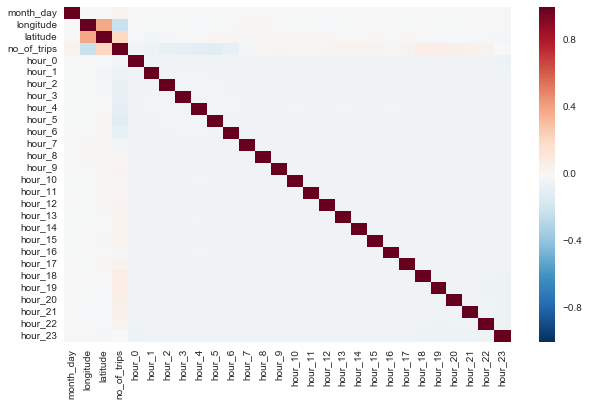

In [105]:
sns.heatmap(trip_count_with_neighborhood.drop(['full_date','pickup_hour'], axis=1).corr())

We notice a correlation between latitude, longitude and the no of trips; also, there is light correlation between the dummy `hour` variables and the no of trips.

I now perform an OLS fit using neighborhood and the pickup hour as predictors. We observe that the R-squared value has a slight increase.

In [106]:
lm = smf.ols(formula='no_of_trips ~ neighborhood + hour_0 + hour_1 + hour_2 + hour_3 + hour_4 + hour_5 + \
             hour_6 + hour_7 + hour_8 + hour_9 + hour_10 + hour_11 + hour_12 + hour_13 + hour_14 + hour_15 + \
             hour_16 + hour_17 + hour_18 + hour_19 + hour_20 + hour_21 + hour_22 + hour_23', data=trip_count_with_neighborhood).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            no_of_trips   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     542.0
Date:                Wed, 15 Jun 2016   Prob (F-statistic):               0.00
Time:                        00:21:44   Log-Likelihood:            -1.0847e+05
No. Observations:               27790   AIC:                         2.171e+05
Df Residuals:                   27688   BIC:                         2.180e+05
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------
Intercept                             2.856e+12   3.28e+12      0.870      0.384     -3.57e+12  9.29e+12
neighborhood[T.Astoria Heights]         -3.8192      0.882     -4.331      0.000        -5.548    -2.091
neighborhood[T.Battery Park City]        3.6901      0.719      5.133      0.000         2.281     5.099
neighborhood[T.Blissville]              -3.1743      1.539     -2.063      0.039        -6.190    -0.159
neighborhood[T.Briarwood]               -3.3259      2.072     -1.605      0.108        -7.386     0.735
neighborhood[T.Bushwick]                 4.2675      2.043      2.089      0.037         0.263     8.272
neighborhood[T.Carnegie Hill]           21.7497      0.718     30.301      0.000        20.343    23.157
neighborhood[T.Central Harlem]          -2.8198      1.122     -2.514      0.012        -5.018    -0.621
neighborhood[T.Chinatown]                0.3731      0.708      0.527      0.598        -1.015     1.761
neighborhood[T.Civic Center]             5.8944      0.703      8.390      0.000         4.517     7.271
neighborhood[T.Clason Point]            -6.0031      8.516     -0.705      0.481       -22.695    10.689
neighborhood[T.Clinton]                 29.5715      0.687     43.029      0.000        28.224    30.919
neighborhood[T.College Point]           -6.8118      4.936     -1.380      0.168       -16.486     2.863
neighborhood[T.Downtown Flushing]        0.4975      2.293      0.217      0.828        -3.996     4.991
neighborhood[T.Dumbo]                   -3.1906      0.882     -3.619      0.000        -4.919    -1.463
neighborhood[T.East Elmhurst]           10.9531      0.737     14.865      0.000         9.509    12.397
neighborhood[T.East Harlem]              0.7767      0.695      1.117      0.264        -0.586     2.140
neighborhood[T.East Village]            13.0591      0.683     19.113      0.000        11.720    14.398
neighborhood[T.East Williamsburg]        1.7436      0.940      1.854      0.064        -0.100     3.587
neighborhood[T.Elmhurst]                 1.0592      1.339      0.791      0.429        -1.565     3.684
neighborhood[T.Financial District]       7.7828      0.690     11.275      0.000         6.430     9.136
neighborhood[T.Flatiron]                39.1314      0.683     57.274      0.000        37.792    40.471
neighborhood[T.Forest Hills]            -0.1925      1.166     -0.165      0.869        -2.477     2.092
neighborhood[T.Forest Hills Gardens]    -2.6603      2.221     -1.198      0.231        -7.013     1.693
neighborhood[T.Fulton Ferry]            -3.8747      1.328     -2.918      0.004        -6.477    -1.272
neighborhood[T.Glendale]                -0.3806      6.031     -0.063      0.950       -12.202    11.441
neighborhood[T.Gramercy]              

Next I perform an OLS with neighborhood, pickup hour, and the day of the week.

We observe only a slight increase beyond what we had seen earlier. It is likely that one of the reasons the pickup day is not a significant predictor is the fact that all weekdays have similar patterns. Perhaps a column that classifies whether the day is a weekday or weekend, can act as a better predictor.  

In [107]:
lm = smf.ols(formula='no_of_trips ~ neighborhood + pickup_day + hour_0 + hour_1 + hour_2 + hour_3 + hour_4 + hour_5 + \
             hour_6 + hour_7 + hour_8 + hour_9 + hour_10 + hour_11 + hour_12 + hour_13 + hour_14 + hour_15 + \
             hour_16 + hour_17 + hour_18 + hour_19 + hour_20 + hour_21 + hour_22 + hour_23', data=trip_count_with_neighborhood).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            no_of_trips   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     517.7
Date:                Wed, 15 Jun 2016   Prob (F-statistic):               0.00
Time:                        00:22:35   Log-Likelihood:            -1.0835e+05
No. Observations:               27790   AIC:                         2.169e+05
Df Residuals:                   27682   BIC:                         2.178e+05
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------
Intercept                             3.129e+12   3.28e+12      0.954      0.340      -3.3e+12  9.55e+12
neighborhood[T.Astoria Heights]         -3.7933      0.884     -4.292      0.000        -5.526    -2.061
neighborhood[T.Battery Park City]        3.7126      0.715      5.189      0.000         2.310     5.115
neighborhood[T.Blissville]              -3.0397      1.535     -1.981      0.048        -6.048    -0.032
neighborhood[T.Briarwood]               -3.1203      2.064     -1.512      0.131        -7.165     0.924
neighborhood[T.Bushwick]                 4.2335      2.035      2.080      0.038         0.245     8.222
neighborhood[T.Carnegie Hill]           21.7782      0.714     30.483      0.000        20.378    23.179
neighborhood[T.Central Harlem]          -2.8760      1.118     -2.572      0.010        -5.068    -0.684
neighborhood[T.Chinatown]                0.3496      0.705      0.496      0.620        -1.033     1.732
neighborhood[T.Civic Center]             5.8863      0.700      8.405      0.000         4.514     7.259
neighborhood[T.Clason Point]            -6.4120      8.483     -0.756      0.450       -23.039    10.215
neighborhood[T.Clinton]                 29.5997      0.685     43.207      0.000        28.257    30.942
neighborhood[T.College Point]           -7.5442      4.917     -1.534      0.125       -17.182     2.093
neighborhood[T.Downtown Flushing]        0.6090      2.284      0.267      0.790        -3.868     5.085
neighborhood[T.Dumbo]                   -3.3148      0.878     -3.775      0.000        -5.036    -1.594
neighborhood[T.East Elmhurst]           10.9676      0.733     14.962      0.000         9.531    12.404
neighborhood[T.East Harlem]              0.7960      0.693      1.149      0.251        -0.562     2.154
neighborhood[T.East Village]            13.0809      0.681     19.220      0.000        11.747    14.415
neighborhood[T.East Williamsburg]        1.6612      0.937      1.774      0.076        -0.175     3.497
neighborhood[T.Elmhurst]                 1.2178      1.334      0.913      0.361        -1.397     3.832
neighborhood[T.Financial District]       7.7849      0.688     11.322      0.000         6.437     9.133
neighborhood[T.Flatiron]                39.1471      0.681     57.517      0.000        37.813    40.481
neighborhood[T.Forest Hills]            -0.2266      1.161     -0.195      0.845        -2.502     2.049
neighborhood[T.Forest Hills Gardens]    -2.4274      2.213     -1.097      0.273        -6.764     1.909
neighborhood[T.Fulton Ferry]            -4.1114      1.323     -3.108      0.002        -6.704    -1.519
neighborhood[T.Glendale]                -1.2314      6.008     -0.205      0.838       -13.008    10.545
neighborhood[T.Gramercy]              

I now introduce dummy variables for the neighborhoods. This is required if we want to use a linear model fit in scikit learn.

In [108]:
neighborhood_dummies = pd.get_dummies(trip_count_with_neighborhood.neighborhood, prefix = 'Nbr')

In [109]:
frames = [trip_count_with_neighborhood, neighborhood_dummies]
trip_count_all_dummies = pd.concat(frames, axis=1)
print trip_count_all_dummies.shape
trip_count_all_dummies.head()

(27790, 112)


full_date  pickup_hour pickup_day  month_day Borough  longitude  \
0  2013-01-01            0    Tuesday          1  Queens -73.915654   
1  2013-01-01            1    Tuesday          1  Queens -73.915654   
2  2013-01-01            2    Tuesday          1  Queens -73.915654   
3  2013-01-01            3    Tuesday          1  Queens -73.915654   
4  2013-01-01            4    Tuesday          1  Queens -73.915654   

    latitude  no_of_trips neighborhood  hour_0      ...        Nbr_Tudor City  \
0  40.768509            2      Astoria     1.0      ...                   0.0   
1  40.768509            6      Astoria     0.0      ...                   0.0   
2  40.768509            7      Astoria     0.0      ...                   0.0   
3  40.768509           10      Astoria     0.0      ...                   0.0   
4  40.768509            7      Astoria     0.0      ...                   0.0   

   Nbr_Turtle Bay  Nbr_Upper East Side  Nbr_Upper West Side  Nbr_Vinegar Hill  \
0             0.0                  0.0                  0.0               0.0   
1             0.0                  0.0                  0.0               0.0   
2             0.0                  0.0                  0.0               0.0   
3             0.0                  0.0                  0.0               0.0   
4             0.0                  0.0                  0.0               0.0   

   Nbr_West Village  Nbr_Whitestone  Nbr_Williamsburg  Nbr_Woodside  \
0               0.0             0.0               0.0           0.0   
1               0.0             0.0               0.0           0.0   
2               0.0             0.0               0.0           0.0   
3               0.0             0.0               0.0           0.0   
4               0.0             0.0               0.0           0.0   

   Nbr_Yorkville  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  

[5 rows x 112 columns]

The following method takes in as arguments the input, output, and the regression model to be used. It returns the R-squared value, mean squared error, and also a histogram of the residuals. The method is called subsequently using various predictor variables for building a lasso, ridge, or elasticnet regression model.

In [110]:
def get_linear_model_metrics(X, y, algo):
    # get the pvalue of X given y. Ignore f-stat for now.
    pvals = feature_selection.f_regression(X, y)[1]
    # start with an empty linear regression object
    # .fit() runs the linear regression function on X and y
    algo.fit(X,y)
    residuals = (y-algo.predict(X)).values
    print residuals
    print 'Mean Squared Error:',(sum(residuals**2))/len(y)

    # print the necessary values
#     print 'Coefficients:', algo.coef_
#     print 'y-intercept:', algo.intercept_
    print 'R-Squared:', algo.score(X,y)
    plt.figure()
    plt.hist(residuals, bins=np.ceil(np.sqrt(len(y))))

    # keep the model
    return algo

For the scikit learn linear model, I exclude all the columns except the neighborhood and pickup hour dummy variables.

Ridge Regression gives us the best fit.

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
[-14.03065035 -10.03065035  -9.03065035 ...,  -4.03065035  -5.03065035
  -6.03065035]
Mean Squared Error: 394.726523576
R-Squared: 0.077837409814

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
[  2.06658534   9.27722554  12.90518353 ...,  -8.05063394  -8.16124178
  -5.62567444]
Mean Squared Error: 143.784765975
R-Squared: 0.664089124239

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
[-14.31399405 -10.31399405  -9.31399405 ...,  -4.31399405  -5.31399405
  -6.31399405]
Mean Squared Error: 420.885774516
R-Squared: 0.0167240030278



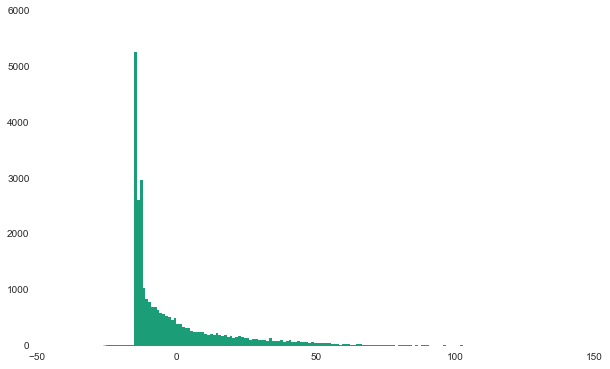

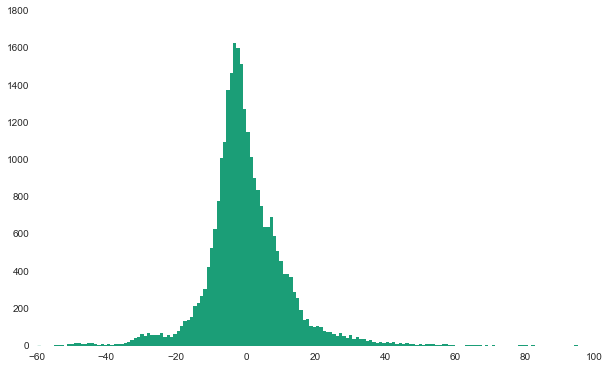

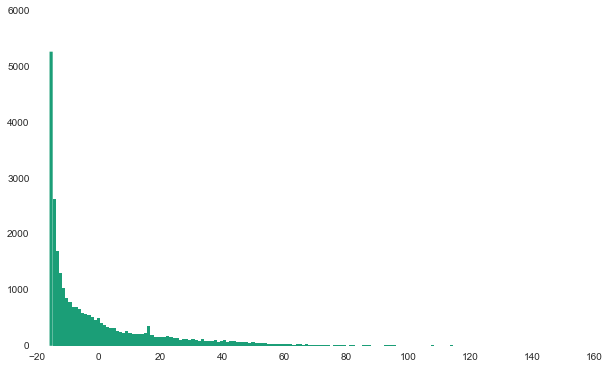

In [131]:
X = trip_count_all_dummies.drop(['full_date','pickup_day','pickup_hour','no_of_trips','Borough','longitude','latitude','neighborhood','month_day'], axis=1)
y = trip_count_all_dummies['no_of_trips']

estimators = [
    linear_model.Lasso(),
    linear_model.Ridge(),
    linear_model.ElasticNet(),
]

for est in estimators:
    print est
    get_linear_model_metrics(X, y, est)
    print

### Combining the weather data

I extract the weather data from the website `www.wunderground.com`. Subsequently, I join the weather data with the trip count data and use the weather parameters as additional predictors.

In [112]:
weather_df = pd.read_csv('https://www.wunderground.com/history/airport/KNYC/2013/1/1/MonthlyHistory.html?&reqdb.zip=&reqdb.magic=&reqdb.wmo=&MR=1&format=1')
weather_df.head()

EST  Max TemperatureF  Mean TemperatureF  Min TemperatureF  \
0  2013-1-1                40                 33                26   
1  2013-1-2                33                 28                22   
2  2013-1-3                32                 28                24   
3  2013-1-4                37                 34                30   
4  2013-1-5                42                 37                32   

   Max Dew PointF  MeanDew PointF  Min DewpointF  Max Humidity  \
0              27              22              9            64   
1              15              11              9            57   
2              17              14             12            68   
3              21              19             18            63   
4              21              19             16            56   

    Mean Humidity   Min Humidity          ...            Max VisibilityMiles  \
0              54             44          ...                             10   
1              48             39          ...                             10   
2              56             43          ...                             10   
3              56             48          ...                             10   
4              48             39          ...                             10   

    Mean VisibilityMiles   Min VisibilityMiles   Max Wind SpeedMPH  \
0                     10                    10                  15   
1                     10                    10                  15   
2                     10                    10                  13   
3                     10                    10                  18   
4                     10                    10                  17   

    Mean Wind SpeedMPH   Max Gust SpeedMPH  PrecipitationIn   CloudCover  \
0                    7                  26             0.00            5   
1                    6                  22             0.00            0   
2                    5                  20             0.00            2   
3                    8                  28             0.00            3   
4                    7                  26             0.00            1   

    Events  WindDirDegrees<br />  
0      NaN             283<br />  
1      NaN             299<br />  
2      NaN             272<br />  
3      NaN             268<br />  
4      NaN             285<br />  

[5 rows x 23 columns]

In [113]:
weather_df.columns

Index([u'EST', u'Max TemperatureF', u'Mean TemperatureF', u'Min TemperatureF',
       u'Max Dew PointF', u'MeanDew PointF', u'Min DewpointF', u'Max Humidity',
       u' Mean Humidity', u' Min Humidity', u' Max Sea Level PressureIn',
       u' Mean Sea Level PressureIn', u' Min Sea Level PressureIn',
       u' Max VisibilityMiles', u' Mean VisibilityMiles',
       u' Min VisibilityMiles', u' Max Wind SpeedMPH', u' Mean Wind SpeedMPH',
       u' Max Gust SpeedMPH', u'PrecipitationIn', u' CloudCover', u' Events',
       u' WindDirDegrees<br />'],
      dtype='object')

In [114]:
weather_df.rename(columns={'Max TemperatureF': 'Max_TemperatureF', 'Mean TemperatureF': 'Mean_TemperatureF', 
                          'Min TemperatureF':'Min_TemperatureF', 'Max Dew PointF':'Max_Dew_PointF',
                          'MeanDew PointF':'MeanDew_PointF', 'Min DewpointF':'Min_DewpointF','Max Humidity':'Max_Humidity',
                           ' Mean Humidity':'Mean_Humidity',' Min Humidity':'Min_Humidity', 
                           ' Max Sea Level PressureIn':'Max_Sea_Level_PressureIn',' Mean Sea Level PressureIn':'Mean_Sea_Level_PressureIn',
                           ' Min Sea Level PressureIn':'Min_Sea_Level_PressureIn',' Max VisibilityMiles':'Max_VisibilityMiles', 
                           ' Mean VisibilityMiles':'Mean_VisibilityMiles',' Min VisibilityMiles':'Min_VisibilityMiles',
                           ' Max Wind SpeedMPH':'Max_Wind_SpeedMPH',' Mean Wind SpeedMPH':'Mean_Wind_SpeedMPH',
                           ' Max Gust SpeedMPH':'Max_Gust_SpeedMPH','PrecipitationIn':'PrecipitationIn', ' CloudCover':'CloudCover', ' Events':'Events',
                           ' WindDirDegrees<br />':'WindDirDegrees'}, inplace=True)

In [115]:
weather_df.columns

Index([u'EST', u'Max_TemperatureF', u'Mean_TemperatureF', u'Min_TemperatureF',
       u'Max_Dew_PointF', u'MeanDew_PointF', u'Min_DewpointF', u'Max_Humidity',
       u'Mean_Humidity', u'Min_Humidity', u'Max_Sea_Level_PressureIn',
       u'Mean_Sea_Level_PressureIn', u'Min_Sea_Level_PressureIn',
       u'Max_VisibilityMiles', u'Mean_VisibilityMiles', u'Min_VisibilityMiles',
       u'Max_Wind_SpeedMPH', u'Mean_Wind_SpeedMPH', u'Max_Gust_SpeedMPH',
       u'PrecipitationIn', u'CloudCover', u'Events', u'WindDirDegrees'],
      dtype='object')

In [116]:
weather_df['WindDirDegrees'] = weather_df['WindDirDegrees'].apply(lambda x: x.split('<')[0]) #Removing the </br> from the 'WinDirDegrees' column

In [117]:
weather_df.head()

EST  Max_TemperatureF  Mean_TemperatureF  Min_TemperatureF  \
0  2013-1-1                40                 33                26   
1  2013-1-2                33                 28                22   
2  2013-1-3                32                 28                24   
3  2013-1-4                37                 34                30   
4  2013-1-5                42                 37                32   

   Max_Dew_PointF  MeanDew_PointF  Min_DewpointF  Max_Humidity  Mean_Humidity  \
0              27              22              9            64             54   
1              15              11              9            57             48   
2              17              14             12            68             56   
3              21              19             18            63             56   
4              21              19             16            56             48   

   Min_Humidity      ...        Max_VisibilityMiles  Mean_VisibilityMiles  \
0            44      ...                         10                    10   
1            39      ...                         10                    10   
2            43      ...                         10                    10   
3            48      ...                         10                    10   
4            39      ...                         10                    10   

   Min_VisibilityMiles  Max_Wind_SpeedMPH  Mean_Wind_SpeedMPH  \
0                   10                 15                   7   
1                   10                 15                   6   
2                   10                 13                   5   
3                   10                 18                   8   
4                   10                 17                   7   

   Max_Gust_SpeedMPH  PrecipitationIn  CloudCover  Events WindDirDegrees  
0                 26             0.00           5     NaN            283  
1                 22             0.00           0     NaN            299  
2                 20             0.00           2     NaN            272  
3                 28             0.00           3     NaN            268  
4                 26             0.00           1     NaN            285  

[5 rows x 23 columns]

In [119]:
print weather_df['Events'].unique()
print weather_df['WindDirDegrees'].unique()
print weather_df['PrecipitationIn'].unique()

[nan 'Rain' 'Fog' 'Fog-Rain' 'Snow' 'Rain-Snow']
['283' '299' '272' '268' '285' '257' '291' '251' '265' '304' '76' '43'
 '160' '316' '38' '356' '318' '323' '237' '270' '297' '292' '311' '284'
 '303' '289' '233' '119' '121']
['0.00' 'T' '0.55' '0.02' '0.09' '0.12' '0.69' '0.07' '0.22' '0.06' '0.04'
 '0.90']


In [120]:
weather_df.loc[(weather_df['PrecipitationIn'] == 'T'),'PrecipitationIn'] = 0 #Replace precipitation 'T' with 0
weather_df['PrecipitationIn'] = weather_df['PrecipitationIn'].astype(float)

In [121]:
weather_df['date'] = weather_df['EST'].apply(lambda x: time.strptime(x, "%Y-%m-%d").tm_mday)

In [123]:
weather_df.head()

EST  Max_TemperatureF  Mean_TemperatureF  Min_TemperatureF  \
0  2013-1-1                40                 33                26   
1  2013-1-2                33                 28                22   
2  2013-1-3                32                 28                24   
3  2013-1-4                37                 34                30   
4  2013-1-5                42                 37                32   

   Max_Dew_PointF  MeanDew_PointF  Min_DewpointF  Max_Humidity  Mean_Humidity  \
0              27              22              9            64             54   
1              15              11              9            57             48   
2              17              14             12            68             56   
3              21              19             18            63             56   
4              21              19             16            56             48   

   Min_Humidity  ...   Mean_VisibilityMiles  Min_VisibilityMiles  \
0            44  ...                     10                   10   
1            39  ...                     10                   10   
2            43  ...                     10                   10   
3            48  ...                     10                   10   
4            39  ...                     10                   10   

   Max_Wind_SpeedMPH  Mean_Wind_SpeedMPH  Max_Gust_SpeedMPH  PrecipitationIn  \
0                 15                   7                 26              0.0   
1                 15                   6                 22              0.0   
2                 13                   5                 20              0.0   
3                 18                   8                 28              0.0   
4                 17                   7                 26              0.0   

   CloudCover  Events  WindDirDegrees  date  
0           5     NaN             283     1  
1           0     NaN             299     2  
2           2     NaN             272     3  
3           3     NaN             268     4  
4           1     NaN             285     5  

[5 rows x 24 columns]

In [122]:
trip_count_all_dummies.head()

full_date  pickup_hour pickup_day  month_day Borough  longitude  \
0  2013-01-01            0    Tuesday          1  Queens -73.915654   
1  2013-01-01            1    Tuesday          1  Queens -73.915654   
2  2013-01-01            2    Tuesday          1  Queens -73.915654   
3  2013-01-01            3    Tuesday          1  Queens -73.915654   
4  2013-01-01            4    Tuesday          1  Queens -73.915654   

    latitude  no_of_trips neighborhood  hour_0      ...        Nbr_Tudor City  \
0  40.768509            2      Astoria     1.0      ...                   0.0   
1  40.768509            6      Astoria     0.0      ...                   0.0   
2  40.768509            7      Astoria     0.0      ...                   0.0   
3  40.768509           10      Astoria     0.0      ...                   0.0   
4  40.768509            7      Astoria     0.0      ...                   0.0   

   Nbr_Turtle Bay  Nbr_Upper East Side  Nbr_Upper West Side  Nbr_Vinegar Hill  \
0             0.0                  0.0                  0.0               0.0   
1             0.0                  0.0                  0.0               0.0   
2             0.0                  0.0                  0.0               0.0   
3             0.0                  0.0                  0.0               0.0   
4             0.0                  0.0                  0.0               0.0   

   Nbr_West Village  Nbr_Whitestone  Nbr_Williamsburg  Nbr_Woodside  \
0               0.0             0.0               0.0           0.0   
1               0.0             0.0               0.0           0.0   
2               0.0             0.0               0.0           0.0   
3               0.0             0.0               0.0           0.0   
4               0.0             0.0               0.0           0.0   

   Nbr_Yorkville  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  

[5 rows x 112 columns]

I now combine the trip data with the weather data using the index 'date' which corresponds to 'month_day' in the `trip_count_all_dummies` dataframe.

In [124]:
trip_and_weather_df = trip_count_all_dummies.set_index('month_day').join(weather_df.set_index('date'))
trip_and_weather_df['month_day'] = trip_and_weather_df.index.values
trip_and_weather_df.reset_index(drop=True, inplace=True)
trip_and_weather_df.head()

full_date  pickup_hour pickup_day Borough  longitude   latitude  \
0  2013-01-01            0    Tuesday  Queens -73.915654  40.768509   
1  2013-01-01            1    Tuesday  Queens -73.915654  40.768509   
2  2013-01-01            2    Tuesday  Queens -73.915654  40.768509   
3  2013-01-01            3    Tuesday  Queens -73.915654  40.768509   
4  2013-01-01            4    Tuesday  Queens -73.915654  40.768509   

   no_of_trips neighborhood  hour_0  hour_1    ...      Mean_VisibilityMiles  \
0            2      Astoria     1.0     0.0    ...                        10   
1            6      Astoria     0.0     1.0    ...                        10   
2            7      Astoria     0.0     0.0    ...                        10   
3           10      Astoria     0.0     0.0    ...                        10   
4            7      Astoria     0.0     0.0    ...                        10   

   Min_VisibilityMiles  Max_Wind_SpeedMPH  Mean_Wind_SpeedMPH  \
0                   10                 15                   7   
1                   10                 15                   7   
2                   10                 15                   7   
3                   10                 15                   7   
4                   10                 15                   7   

   Max_Gust_SpeedMPH  PrecipitationIn  CloudCover  Events  WindDirDegrees  \
0                 26              0.0           5     NaN             283   
1                 26              0.0           5     NaN             283   
2                 26              0.0           5     NaN             283   
3                 26              0.0           5     NaN             283   
4                 26              0.0           5     NaN             283   

   month_day  
0          1  
1          1  
2          1  
3          1  
4          1  

[5 rows x 135 columns]

In [126]:
trip_and_weather_df.columns.values

array(['full_date', 'pickup_hour', 'pickup_day', 'Borough', 'longitude',
       'latitude', 'no_of_trips', 'neighborhood', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'Nbr_Astoria',
       'Nbr_Astoria Heights', 'Nbr_Battery Park City', 'Nbr_Blissville',
       'Nbr_Briarwood', 'Nbr_Bushwick', 'Nbr_Carnegie Hill',
       'Nbr_Central Harlem', 'Nbr_Chinatown', 'Nbr_Civic Center',
       'Nbr_Clason Point', 'Nbr_Clinton', 'Nbr_College Point',
       'Nbr_Downtown Flushing', 'Nbr_Dumbo', 'Nbr_East Elmhurst',
       'Nbr_East Harlem', 'Nbr_East Village', 'Nbr_East Williamsburg',
       'Nbr_Elmhurst', 'Nbr_Financial District', 'Nbr_Flatiron',
       'Nbr_Forest Hills', 'Nbr_Forest Hills Gardens', 'Nbr_Fulton Ferry',
       'Nbr_Glendale', 'Nbr_Gramercy', '

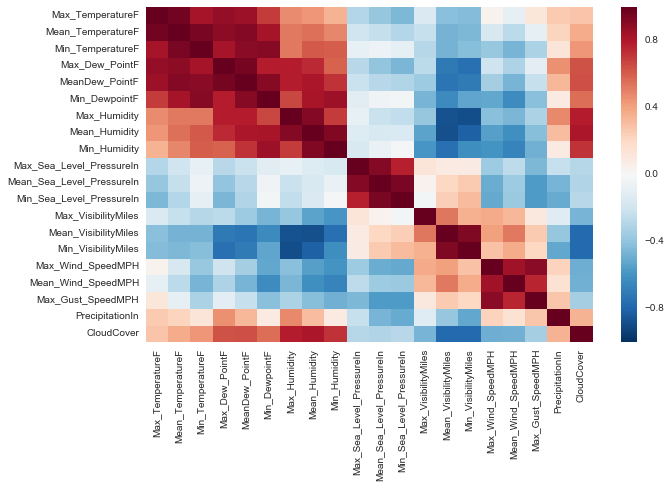

In [127]:
sns.heatmap(trip_and_weather_df[['Max_TemperatureF', 'Mean_TemperatureF', 'Min_TemperatureF',\
       'Max_Dew_PointF', 'MeanDew_PointF', 'Min_DewpointF', 'Max_Humidity',\
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressureIn',\
       'Mean_Sea_Level_PressureIn', 'Min_Sea_Level_PressureIn',\
       'Max_VisibilityMiles', 'Mean_VisibilityMiles',\
       'Min_VisibilityMiles', 'Max_Wind_SpeedMPH', 'Mean_Wind_SpeedMPH',\
       'Max_Gust_SpeedMPH', 'PrecipitationIn', 'CloudCover',\
       'WindDirDegrees']].corr())

The heatmap of the weather data tells us that attributes such as max and min temperatures, max and min humidity, max and min sea level pressure are autocorrelated. Thus, as predictors, I will choose only the mean values for these weather attributes. All the max and min values are therefore dropped while performing linear model fits in scikit-learn and statsmodels.

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
[-13.79953573  -9.79953573  -8.79953573 ...,  -4.33230089  -5.33230089
  -6.33230089]
Mean Squared Error: 394.158334267
R-Squared: 0.0791648172553

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
[  3.53152498  10.70624067  14.33421039 ...,  -9.66544016  -9.7766061
  -7.24979329]
Mean Squared Error: 142.386189653
R-Squared: 0.667356487049

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
[-13.87091042  -9.87091042  -8.87091042 ...,  -4.8660534   -5.8660534
  -6.8660534 ]
Mean Squared Error: 420.207499437
R-Squared: 0.0183085935392



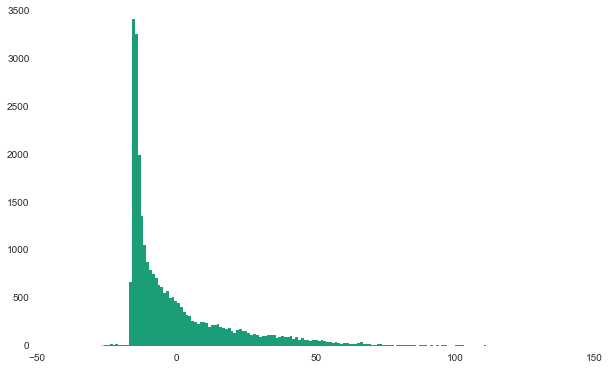

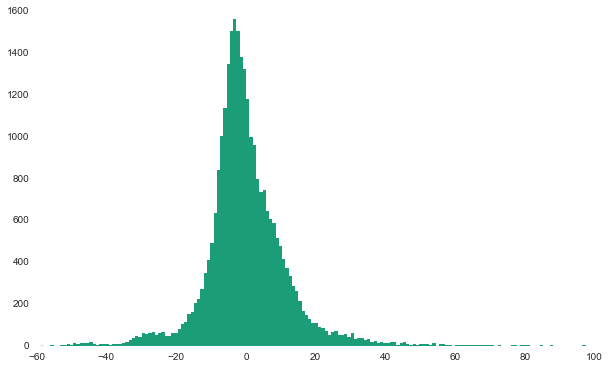

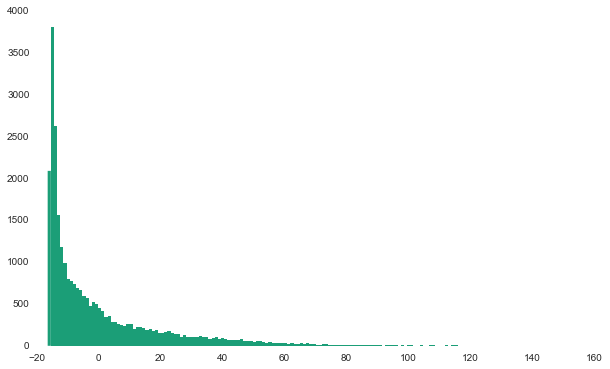

In [134]:
X = trip_and_weather_df.drop(['full_date','pickup_day','pickup_hour','no_of_trips','Borough','longitude','latitude',\
                              'neighborhood','month_day','Events','Max_TemperatureF','Min_TemperatureF','Max_Dew_PointF',\
                              'Min_DewpointF','Max_Humidity','Min_Humidity', 'Max_Sea_Level_PressureIn','Min_Sea_Level_PressureIn',\
                              'Max_VisibilityMiles','Min_VisibilityMiles','Max_Wind_SpeedMPH','EST','month_day','Events'], axis=1)
y = trip_and_weather_df['no_of_trips']

estimators = [
    linear_model.Lasso(),
    linear_model.Ridge(),
    linear_model.ElasticNet(),
]

for est in estimators:
    print est
    get_linear_model_metrics(X, y, est)
    print

Once again, Ridge Regression gives us the best fit.

I also perform another linear model fit with statsmodels which gives me simialr results as the Ridge regression fit on scikit-learn.

In [135]:
lm = smf.ols(formula='no_of_trips ~ neighborhood + pickup_day + hour_0 + hour_1 + hour_2 + hour_3 + hour_4 + hour_5 + \
             hour_6 + hour_7 + hour_8 + hour_9 + hour_10 + hour_11 + hour_12 + hour_13 + hour_14 + hour_15 + \
             hour_16 + hour_17 + hour_18 + hour_19 + hour_20 + hour_21 + hour_22 + hour_23 + \
             Mean_TemperatureF + MeanDew_PointF + Mean_Humidity + Mean_Sea_Level_PressureIn + Mean_VisibilityMiles + \
             Mean_Wind_SpeedMPH + Max_Gust_SpeedMPH + PrecipitationIn + CloudCover', data=trip_and_weather_df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            no_of_trips   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     481.4
Date:                Wed, 15 Jun 2016   Prob (F-statistic):               0.00
Time:                        01:07:09   Log-Likelihood:            -1.0828e+05
No. Observations:               27790   AIC:                         2.168e+05
Df Residuals:                   27673   BIC:                         2.178e+05
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------
Intercept                             -133.3154     20.294     -6.569      0.000      -173.092   -93.538
neighborhood[T.Astoria Heights]         -3.5950      0.830     -4.329      0.000        -5.223    -1.967
neighborhood[T.Battery Park City]        3.5699      0.698      5.118      0.000         2.203     4.937
neighborhood[T.Blissville]              -3.2335      1.510     -2.142      0.032        -6.192    -0.275
neighborhood[T.Briarwood]               -3.1801      2.058     -1.546      0.122        -7.213     0.853
neighborhood[T.Bushwick]                 4.5344      2.008      2.258      0.024         0.598     8.471
neighborhood[T.Carnegie Hill]           21.5885      0.682     31.659      0.000        20.252    22.925
neighborhood[T.Central Harlem]          -2.7562      1.099     -2.508      0.012        -4.910    -0.602
neighborhood[T.Chinatown]                0.3913      0.703      0.557      0.578        -0.986     1.768
neighborhood[T.Civic Center]             6.0103      0.684      8.785      0.000         4.669     7.351
neighborhood[T.Clason Point]            -6.8035      8.461     -0.804      0.421       -23.388     9.781
neighborhood[T.Clinton]                 29.5181      0.679     43.497      0.000        28.188    30.848
neighborhood[T.College Point]           -7.1763      4.903     -1.464      0.143       -16.787     2.434
neighborhood[T.Downtown Flushing]        0.6422      2.278      0.282      0.778        -3.822     5.106
neighborhood[T.Dumbo]                   -3.1612      0.853     -3.705      0.000        -4.834    -1.489
neighborhood[T.East Elmhurst]           11.1326      0.708     15.726      0.000         9.745    12.520
neighborhood[T.East Harlem]              0.7964      0.691      1.153      0.249        -0.558     2.151
neighborhood[T.East Village]            13.0824      0.679     19.273      0.000        11.752    14.413
neighborhood[T.East Williamsburg]        1.7524      0.934      1.876      0.061        -0.079     3.584
neighborhood[T.Elmhurst]                 1.1816      1.331      0.888      0.375        -1.426     3.790
neighborhood[T.Financial District]       7.7830      0.686     11.349      0.000         6.439     9.127
neighborhood[T.Flatiron]                39.1504      0.679     57.675      0.000        37.820    40.481
neighborhood[T.Forest Hills]            -0.2112      1.158     -0.182      0.855        -2.481     2.059
neighborhood[T.Forest Hills Gardens]    -2.5263      2.207     -1.145      0.252        -6.852     1.800
neighborhood[T.Fulton Ferry]            -4.1311      1.319     -3.131      0.002        -6.717    -1.545
neighborhood[T.Glendale]                -0.8960      5.993     -0.150      0.881       -12.643    10.851
neighborhood[T.Gramercy]              

### Decision Tree Regressor

Finally, I perform a decision treee regression with cross-validation using a train-test split on the dataset. I do a grid search to find the optimum max_depth for the tree. The min_samples_split has been assigned to a default 2.

In [140]:
X = trip_and_weather_df.drop(['full_date','pickup_day','pickup_hour','no_of_trips','Borough','longitude','latitude',\
                              'neighborhood','month_day','Events','Max_TemperatureF','Min_TemperatureF','Max_Dew_PointF',\
                              'Min_DewpointF','Max_Humidity','Min_Humidity', 'Max_Sea_Level_PressureIn','Min_Sea_Level_PressureIn',\
                              'Max_VisibilityMiles','Min_VisibilityMiles','Max_Wind_SpeedMPH','EST','month_day','Events'], axis=1)

y = trip_and_weather_df['no_of_trips']

train_data,test_data,train_op,test_op = train_test_split(X,y,test_size=0.2)
print 'Train Data size: %s' % (train_data.shape,)
print 'Test Data size: %s' % (test_data.shape,)

for max_depth in range(1, 26):
    regressor = DecisionTreeRegressor(criterion='mse', max_depth=max_depth, max_features=None,
               max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, presort=False, random_state=None,
               splitter='best')
    print(regressor)
    regressor.fit(train_data,train_op)
    print 'Train Data regressor score: %f' %(regressor.score(train_data,train_op))

    op = regressor.predict(test_data)

    print 'Mean Squared Error: %f' %sklearn.metrics.mean_squared_error(test_op,op)
    print 'Median Absolute Error: %f' %sklearn.metrics.median_absolute_error(test_op,op)
    print 'Test set R-squared: %f' %sklearn.metrics.r2_score(test_op,op)

Train Data size: (22232, 113)
Test Data size: (5558, 113)
DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
Train Data regressor score: 0.171595
Mean Squared Error: 355.657680
Median Absolute Error: 12.008088
Test set R-squared: 0.151092
DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
Train Data regressor score: 0.244180
Mean Squared Error: 333.656682
Median Absolute Error: 11.893222
Test set R-squared: 0.203605
DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, pre

A <b>max_depth of 20</b> gives us the best result on the test dataset.

* Train Data Regressor score of 0.8955
* Mean Squared Error of 98.45
* Median Absolute Error of 3.116
* R-squared value for test data = 0.765

### Visualization of fare amount and tips on the entire dataset

The following blocks of code contain analysis of fare amount and tip amount for all taxi trips i.e. the entire dataset.

First I look at the distribution of mean tip amount received by drivers.

Wall time: 22.5 s


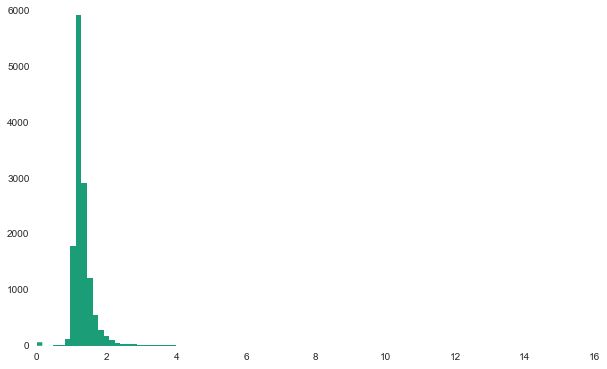

In [141]:
%%time

trip_full_df.groupby('medallion')['tip_amount'].mean().hist(bins=100)

One possible reason the graph shows so many drivers getting low tips is that the data gets skewed with a number of records contain `tip_amount = 0`. If I remove these records and plot the histogram, the resulting histogram will be a more accurate portrayal of the average tip amount received by drivers.

Wall time: 7.69 s


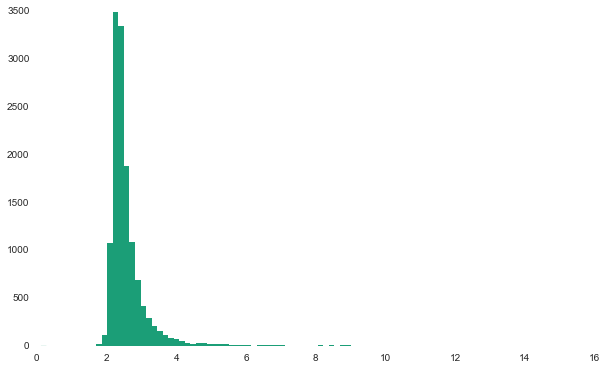

In [143]:
%%time

trip_full_df[trip_full_df.tip_amount != 0].groupby('medallion')['tip_amount'].mean().hist(bins=100)

I was interested to look at the relationship between tip amount and parameters such as trip distance, fare amount. I also looked at the relationship between fare amount and trip distance.

For this analysis, I only looked at the first 500,000 records and not the entire dataset.

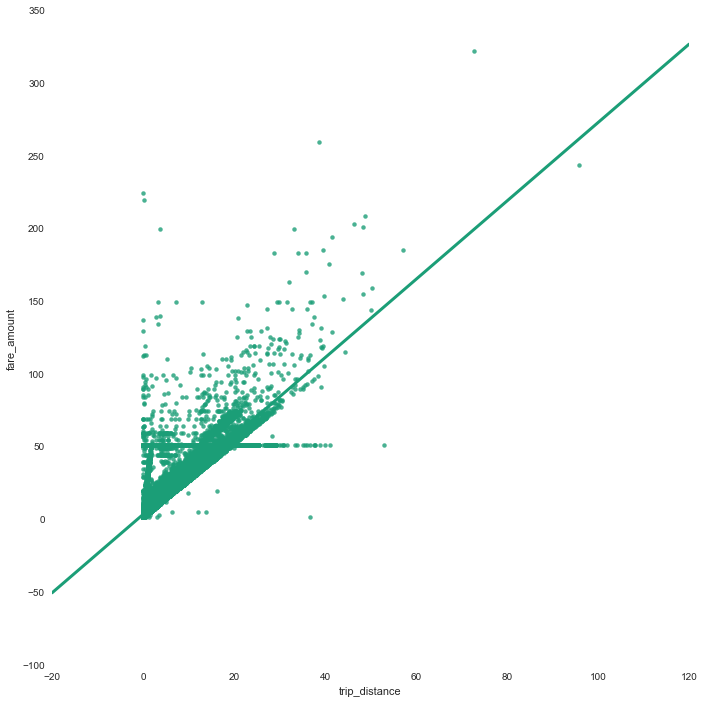

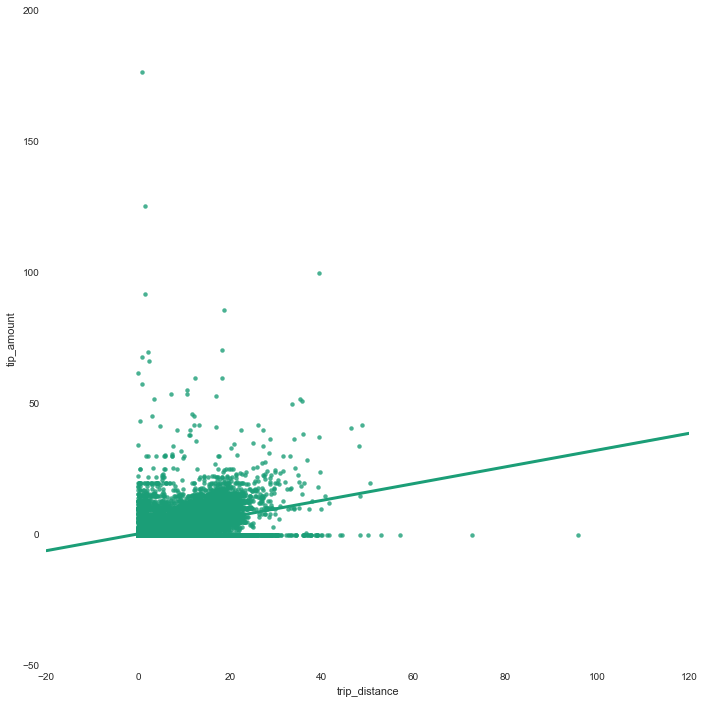

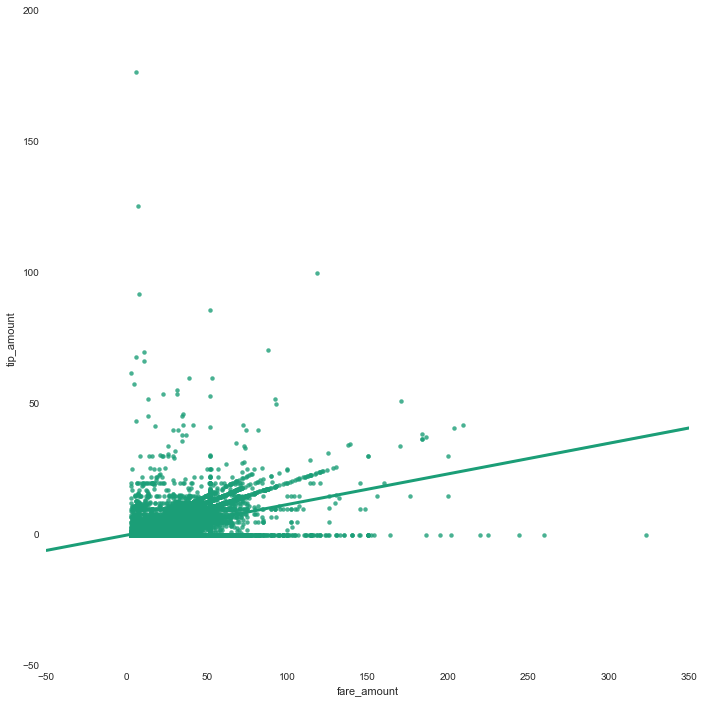

In [144]:
trip_full_df['trip_distance'] = trip_full_df['trip_distance'].astype(float)
trip_full_df['fare_amount'] = trip_full_df['fare_amount'].astype(float)
trip_full_df['tip_amount'] = trip_full_df['tip_amount'].astype(float)
trip_full_df['total_amount'] = trip_full_df['total_amount'].astype(float)

fare_data_head = trip_full_df.head(500000)

sns.lmplot('trip_distance', 'fare_amount', fare_data_head[fare_data_head.trip_distance > 0],size = 10)
sns.lmplot('trip_distance', 'tip_amount', fare_data_head[fare_data_head.trip_distance > 0],size = 10)
sns.lmplot('fare_amount', 'tip_amount', fare_data_head[fare_data_head.trip_distance > 0],size = 10)

The relationship between tip amount and fare amount shows a a linear characteristic with several specific slopes (probably at 10%, 15%, 20% and so on).

Fare amount as a function of trip distance is also linear as expected. However, it's interesting to note that there is a constant fare amount of $52 for several trips, which is irrespective of the trip distance. This turns out to be the constant fare charged for a trip to the LaGuardia Airport.

I then looked at the distribution of the median tip fraction received by individual drivers, by grouping by the medallion numbers.

Next, I look at the overall distribution of the tip fraction. Only records for which tip fraction lies between 0 and 0.5 are looked at.

Wall time: 4.69 s


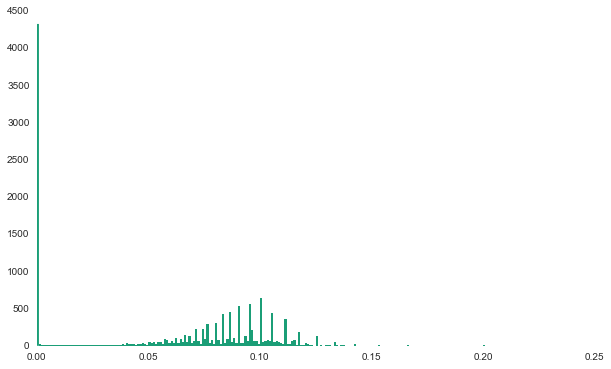

In [145]:
%%time

trip_full_df['tip_fraction'] = trip_full_df['tip_amount']/trip_full_df['fare_amount']
trip_full_df.groupby('medallion')['tip_fraction'].median().hist(bins=250)

Wall time: 41.9 s


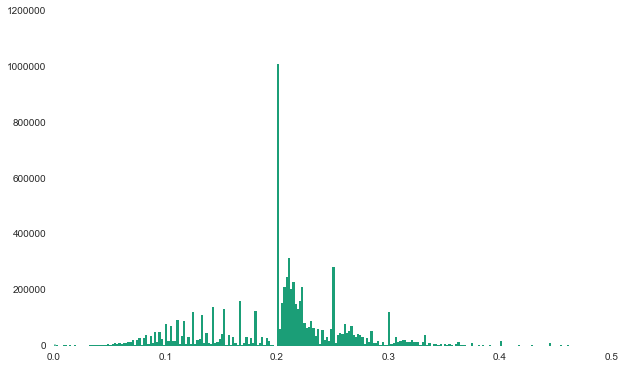

In [146]:
%%time

trip_full_df[(trip_full_df['tip_fraction'] > 0) & (trip_full_df['tip_fraction'] < 0.5)]['tip_fraction'].hist(bins=250)

There is a distinct spike at 0.2 or 20% tip. Also, a tip fraction of greater than 0.2 is more common than less.

Finally, I wrap it up by looking at the distribution of log of tips, since tip amounts in general was seen to be tail-heavy.

Wall time: 6min 46s


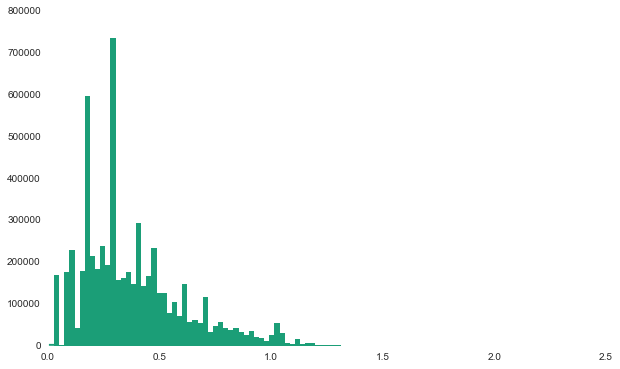

In [147]:
%%time

trip_full_df['tip_amount_log'] = trip_full_df['tip_amount'].apply(np.log10)

trip_full_df[trip_full_df['tip_amount_log'] > 0]['tip_amount_log'].hist(bins=100)

# Visualizing Pickups and Dropoffs for January 2013 at different times of the day

In [148]:
from bokeh.plotting import figure, output_notebook, show
import datashader as ds

I load only the latitude and longitude data of the overall NYC Taxi dataset into a new dataframe. I first plot a histogram of the latitudes and longitudes of the pickup locations to see where most trips take place. I then use Datashader library to visualize regions where, as an aggregate, the number of pickups are more than the number of dropoffs and vice versa.

In [149]:
%time 
df = pd.read_csv('../nyc_taxi_files/trip_data_files/trip_data_1.csv', usecols= \
                       ['pickup_longitude', 'pickup_latitude', 'pickup_datetime', 'dropoff_datetime', 'dropoff_longitude','dropoff_latitude', 'passenger_count'])
df.tail()

Wall time: 0 ns


pickup_datetime     dropoff_datetime  passenger_count  \
14776610  2013-01-06 04:58:23  2013-01-06 05:11:24                1   
14776611  2013-01-08 14:42:04  2013-01-08 14:50:27                1   
14776612  2013-01-10 13:29:23  2013-01-10 13:34:45                1   
14776613  2013-01-06 16:30:15  2013-01-06 16:42:26                1   
14776614  2013-01-05 20:38:46  2013-01-05 20:43:06                1   

          pickup_longitude  pickup_latitude  dropoff_longitude  \
14776610        -73.989029        40.759327         -73.953743   
14776611        -73.993042        40.733990         -73.982483   
14776612        -73.979553        40.785011         -73.968262   
14776613        -73.968002        40.762161         -73.985992   
14776614        -73.982224        40.766670         -73.989212   

          dropoff_latitude  
14776610         40.770672  
14776611         40.724823  
14776612         40.788158  
14776613         40.770542  
14776614         40.773636

In [150]:
df['pickup_hour']=df['pickup_datetime'].apply(lambda x: time.strptime(x, "%Y-%m-%d %H:%M:%S").tm_hour)
df['dropoff_hour']=df['dropoff_datetime'].apply(lambda x: time.strptime(x, "%Y-%m-%d %H:%M:%S").tm_hour)

In [151]:
df.tail()

pickup_datetime     dropoff_datetime  passenger_count  \
14776610  2013-01-06 04:58:23  2013-01-06 05:11:24                1   
14776611  2013-01-08 14:42:04  2013-01-08 14:50:27                1   
14776612  2013-01-10 13:29:23  2013-01-10 13:34:45                1   
14776613  2013-01-06 16:30:15  2013-01-06 16:42:26                1   
14776614  2013-01-05 20:38:46  2013-01-05 20:43:06                1   

          pickup_longitude  pickup_latitude  dropoff_longitude  \
14776610        -73.989029        40.759327         -73.953743   
14776611        -73.993042        40.733990         -73.982483   
14776612        -73.979553        40.785011         -73.968262   
14776613        -73.968002        40.762161         -73.985992   
14776614        -73.982224        40.766670         -73.989212   

          dropoff_latitude  pickup_hour  dropoff_hour  
14776610         40.770672            4             5  
14776611         40.724823           14            14  
14776612         40.788158           13            13  
14776613         40.770542           16            16  
14776614         40.773636           20            20

In [152]:
df.describe()

passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
count     1.477662e+07      1.477662e+07     1.477662e+07       1.477653e+07   
mean      1.697372e+00     -7.263634e+01     4.001440e+01      -7.259443e+01   
std       1.365396e+00      1.013819e+01     7.789904e+00       1.028860e+01   
min       0.000000e+00     -2.771285e+03    -3.547921e+03      -2.350956e+03   
25%       1.000000e+00     -7.399188e+01     4.073551e+01                NaN   
50%       1.000000e+00     -7.398166e+01     4.075315e+01                NaN   
75%       2.000000e+00     -7.396684e+01     4.076729e+01                NaN   
max       2.550000e+02      1.124042e+02     3.310365e+03       2.228738e+03   

       dropoff_latitude   pickup_hour  dropoff_hour  
count      1.477653e+07  1.477662e+07  1.477662e+07  
mean       3.999219e+01  1.358165e+01  1.358404e+01  
std        7.537067e+00  6.401632e+00  6.461708e+00  
min       -3.547921e+03  0.000000e+00  0.000000e+00  
25%                 NaN  9.000000e+00  9.000000e+00  
50%                 NaN  1.400000e+01  1.400000e+01  
75%                 NaN  1.900000e+01  1.900000e+01  
max        3.477106e+03  2.300000e+01  2.300000e+01

-73.98217


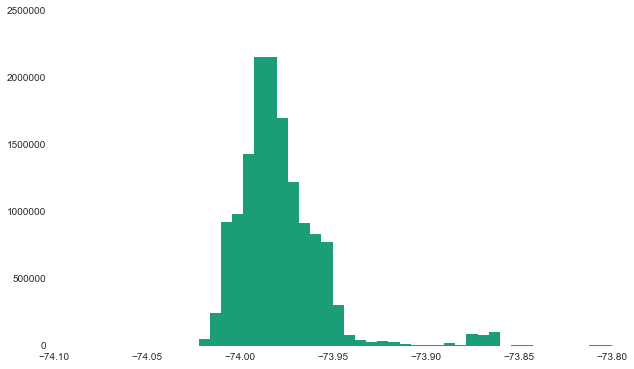

In [153]:
print df[(df['pickup_longitude']>-74.1)&(df['pickup_longitude']<-73.8)]['pickup_longitude'].median()
df[(df['pickup_longitude']>-74.1)&(df['pickup_longitude']<-73.8)]['pickup_longitude'].hist(bins=50)

40.753811


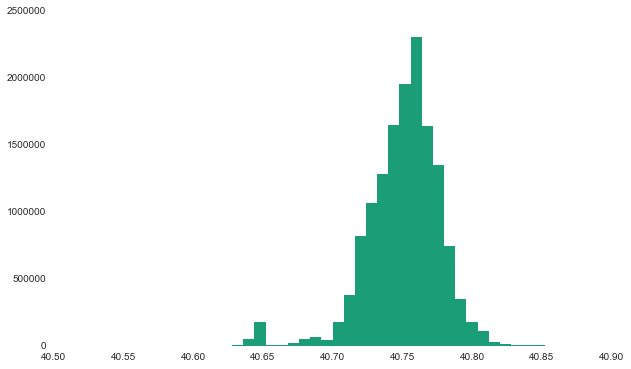

In [154]:
print df[(df['pickup_latitude']>40.6)&(df['pickup_latitude']<40.9)]['pickup_latitude'].median()
df[(df['pickup_latitude']>40.5)&(df['pickup_latitude']<40.9)]['pickup_latitude'].hist(bins=50)

#### I Define a simple bokeh plot. Datashader, which will be used for visualization extends from bokeh

In [155]:
output_notebook()

x_range=(-74.05,-73.8)
y_range=(40.7,40.8)

def base_plot(tools='pan,wheel_zoom,reset',plot_width=900, plot_height=600, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,**plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p
    
options = dict(line_color=None, fill_color='blue', size=5)

from IPython.core.display import HTML, display
display(HTML("<style>.container { width:90% !important; }</style>"))

Loading BokehJS ...

In [156]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Greys9
Greys9_r = list(reversed(Greys9))[:-2]

In [157]:
def draw_pickup_dropoff_maps(hour_start, hour_end):    
   
    '''
    Creates a datashader image of densities of pickup and dropoffs.
    Args:
        hour_start (int): Varies between 0 to 23. Taxi trips starting this hour will be considered.
        hour_end (int): Varies between 1 to 24. Taxi trips ending at this hour will be considered.
        
    Returns:
        img (stack image): datashader image interpolating total number of pickups and dropoffs.        
    '''
    
    cvs = ds.Canvas(plot_width=900, plot_height=600, x_range=x_range, y_range=y_range)

    # Pickup map
    pickup_df = df[(df['pickup_hour'] >= hour_start) & (df['pickup_hour']<hour_end)]
    agg1 = cvs.points(pickup_df, 'pickup_longitude', 'pickup_latitude')

    # Dropoff map
    dropoff_df = df[(df['dropoff_hour'] >= hour_start) & (df['dropoff_hour']<hour_end)]
    agg2 = cvs.points(dropoff_df, 'dropoff_longitude', 'dropoff_latitude')

    img1=tf.interpolate(agg1.where(agg1>agg2), cmap=["lightblue", 'blue'], how='eq_hist')
    img2=tf.interpolate(agg2.where(agg2>agg1), cmap=["lightpink", 'red'], how='eq_hist')

    img = tf.stack(img1,img2)
#     return tf.dynspread(img, threshold=0.1, max_px=4)
    return img

Using the method above, I proceed to visualize the nature of taxi trips as a day passes by. Regions where pickups are greater are marked as blue while regions where dropoffs are greater are marked red.

Shown below are 12 visualizations of pickup and dropoff trends for 2 hour time periods. I start with the trips between 12 to 2 AM and end with trips between 10 PM to 12 AM.

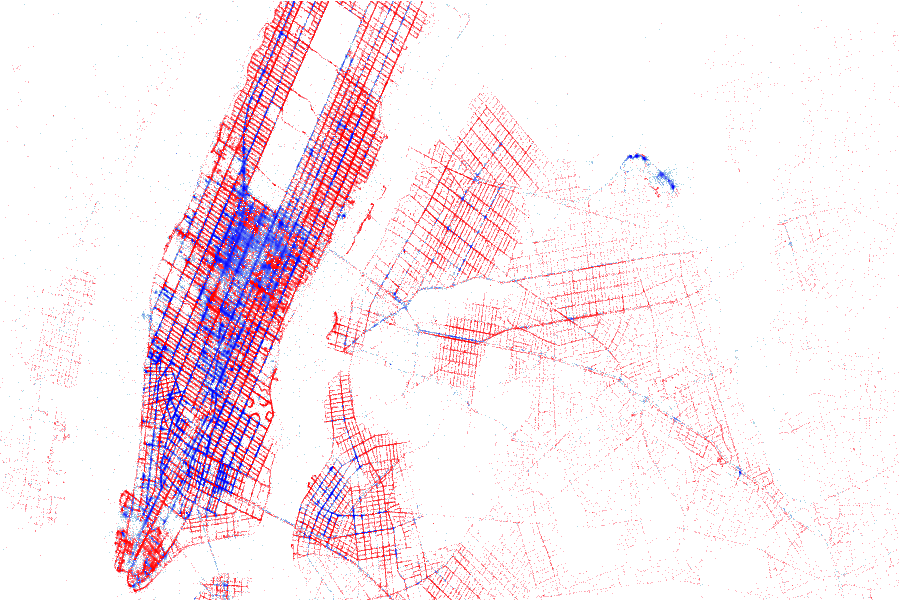

In [158]:
img=draw_pickup_dropoff_maps(0, 2)
img

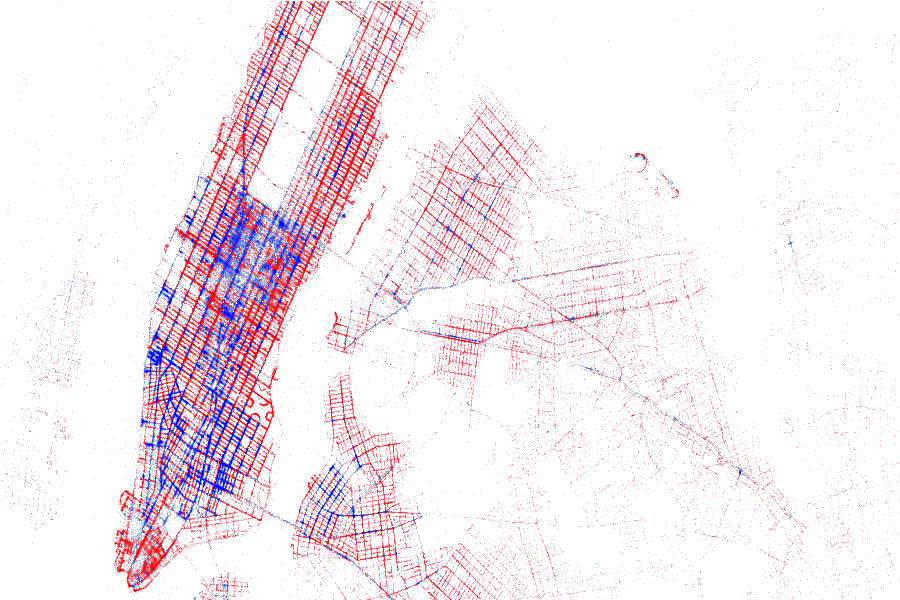

In [159]:
img=draw_pickup_dropoff_maps(2, 4)
img

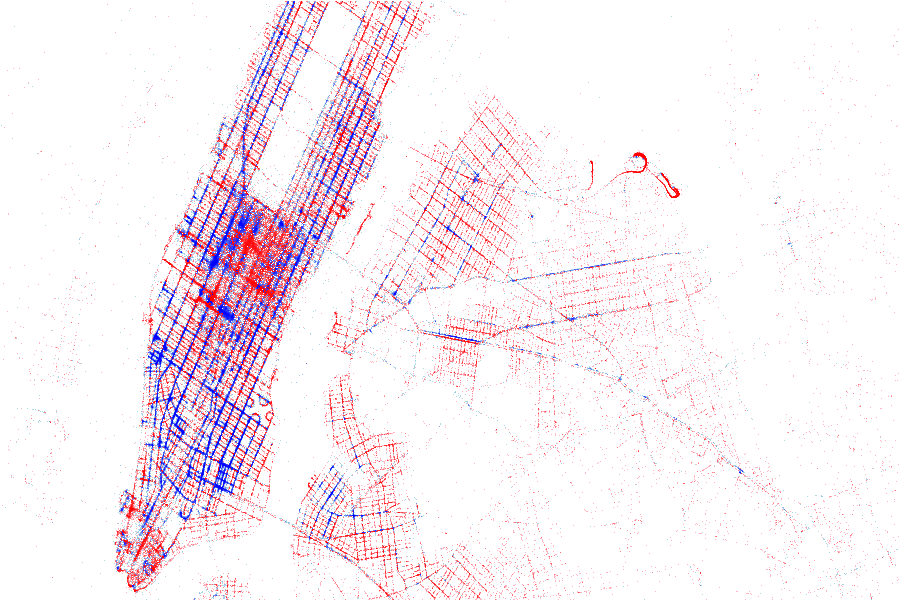

In [160]:
img=draw_pickup_dropoff_maps(4, 6)
img

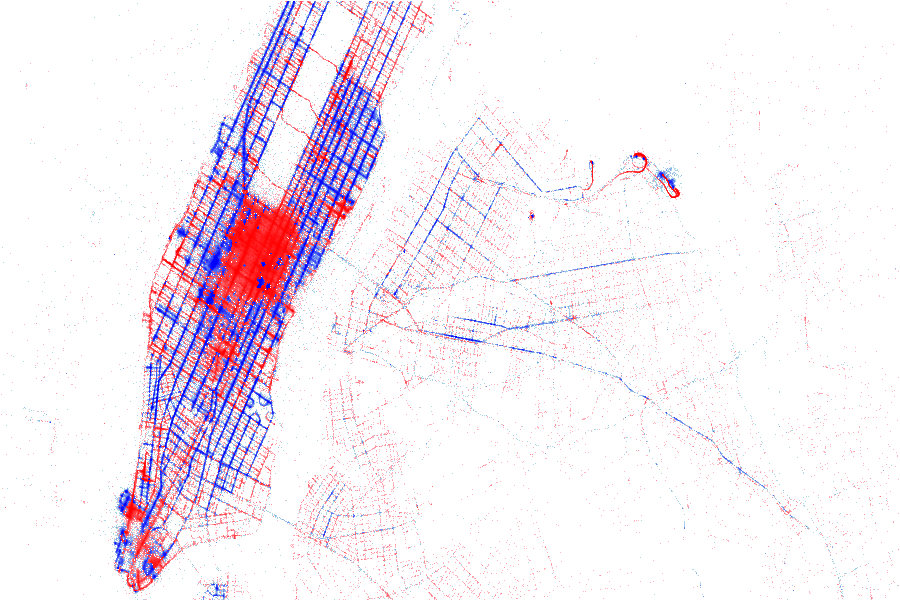

In [161]:
img=draw_pickup_dropoff_maps(6, 8)
img

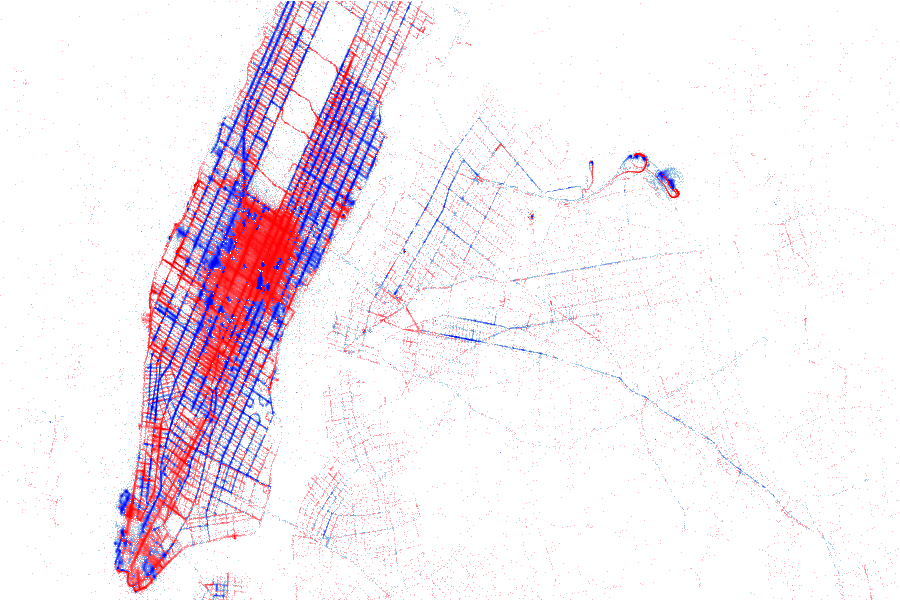

In [162]:
img=draw_pickup_dropoff_maps(8, 10)
img

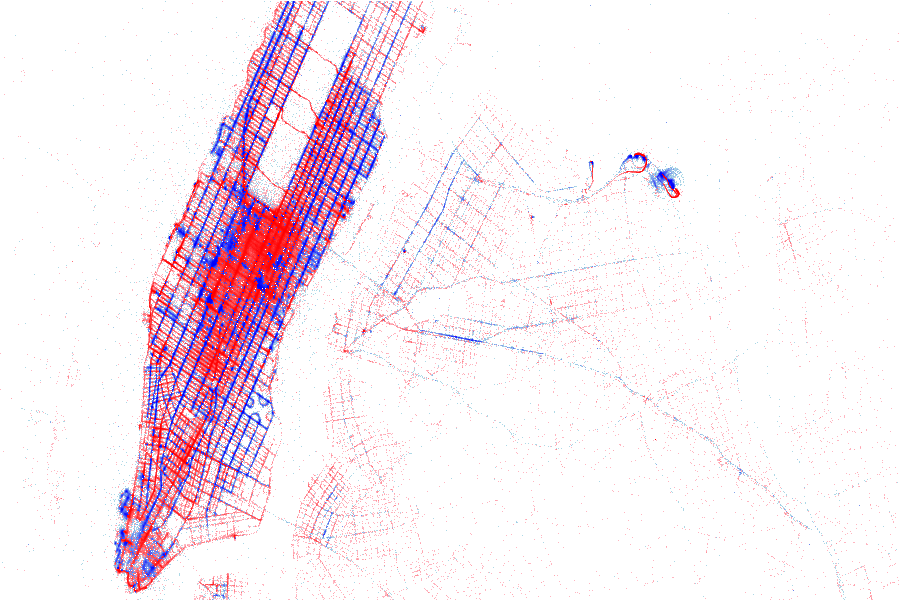

In [163]:
img=draw_pickup_dropoff_maps(10, 12)
img

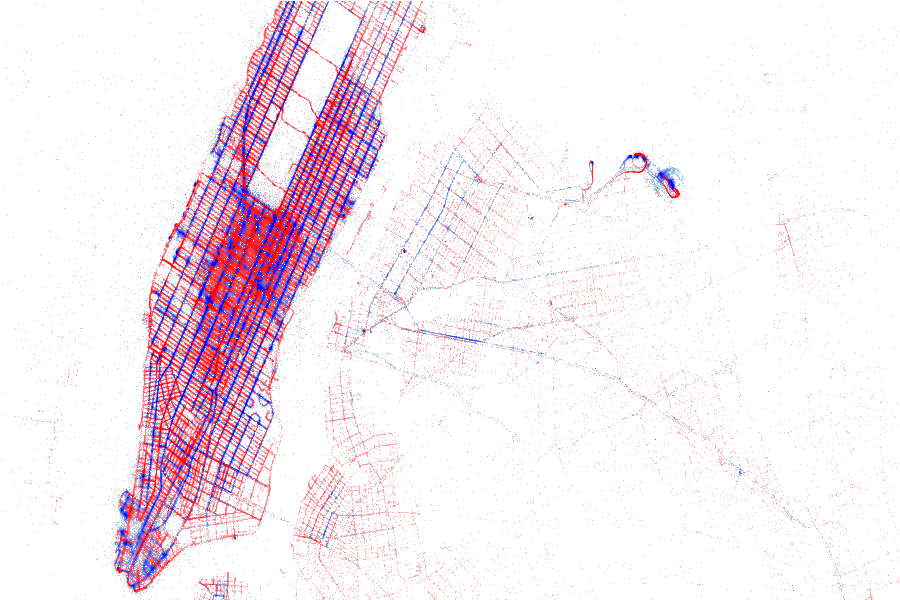

In [164]:
img=draw_pickup_dropoff_maps(12, 14)
img

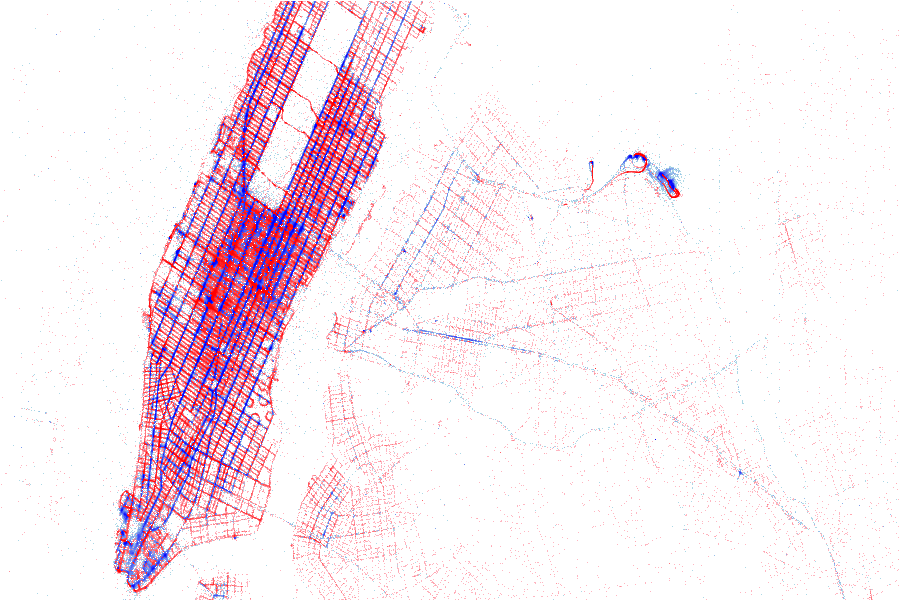

In [165]:
img=draw_pickup_dropoff_maps(14, 16)
img

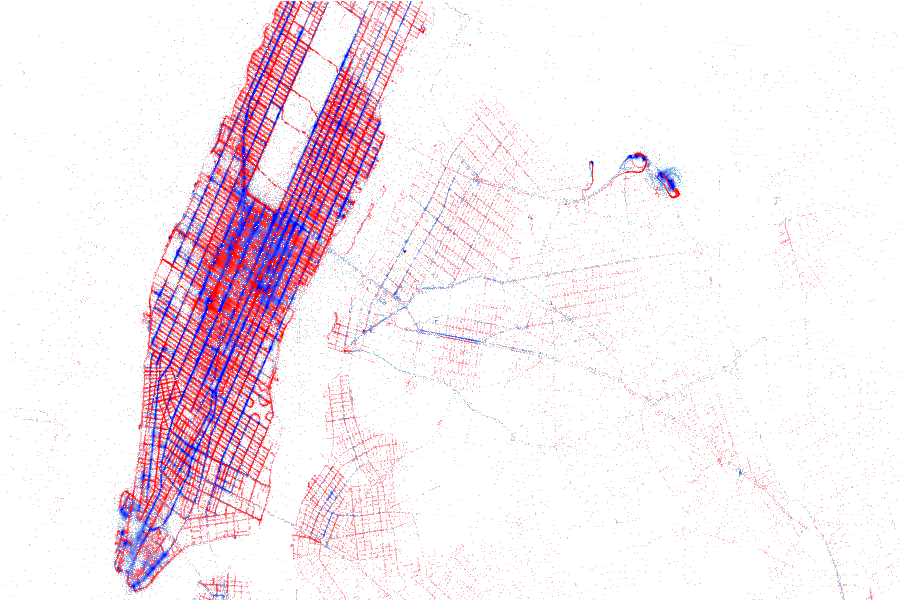

In [166]:
img=draw_pickup_dropoff_maps(16, 18)
img

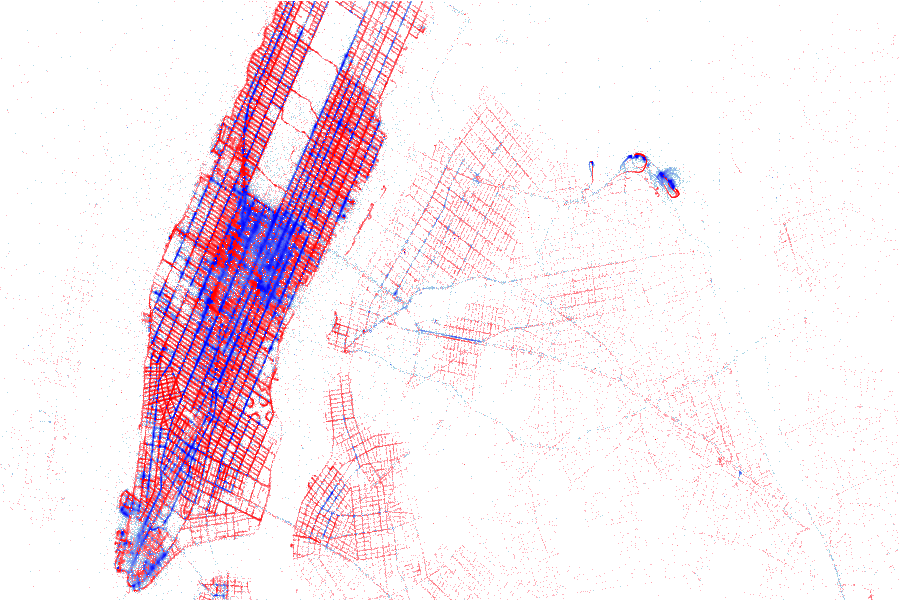

In [167]:
img=draw_pickup_dropoff_maps(18, 20)
img

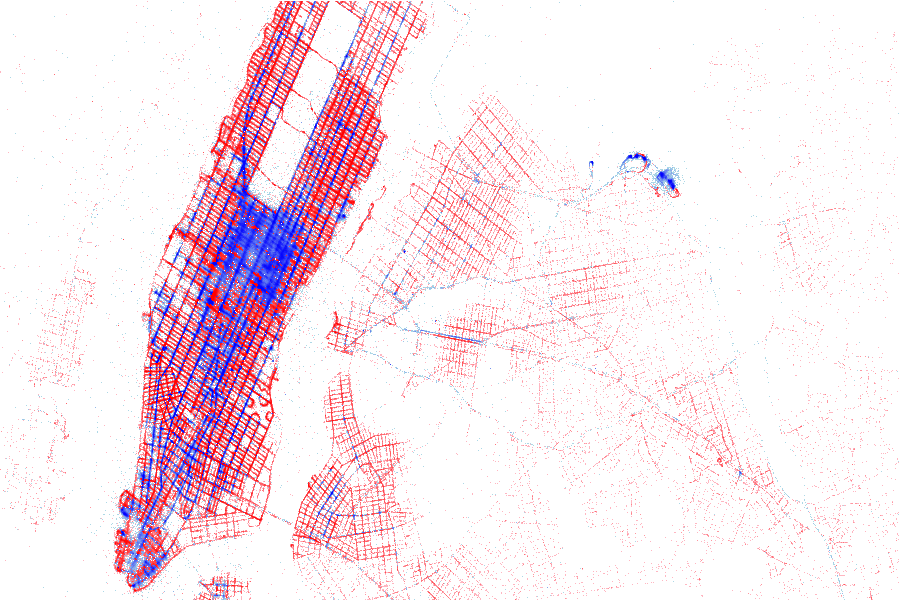

In [168]:
img=draw_pickup_dropoff_maps(20, 22)
img

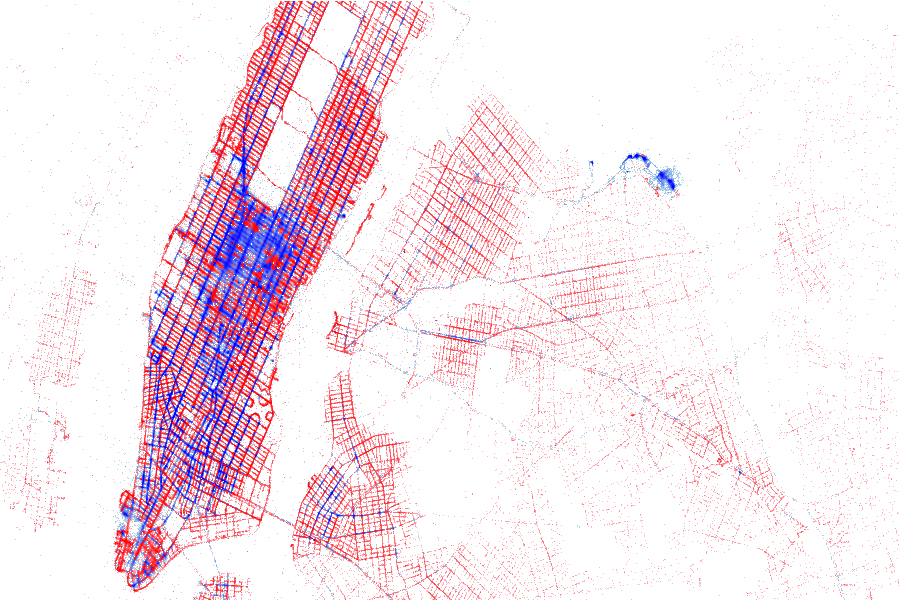

In [169]:
img=draw_pickup_dropoff_maps(22, 24)
img

## Project Summary

* NYC Yellow taxi trips have been losing out to Uber and have had fewer trips on both 2014 and 2015 cmpared to previous year.
* Maximum taxi trips take place between 6 to 8 PM i.e. after work hours.
* A sample subset of the overall dataset was used for modeling the trip counts.
* Trip counts were calculated using groupby function on pickup_hour, neighborhood, and date.
* Linear and random forest regression models using both statsmodels and scikit-learn were used for modeling.
* NYC neighborhoods and weather data were joined to the trip data in order to create the overall dataset. 
* Using a decision tree regressor with a depth of 20 gave us the best fit during cross-validation.
* Tip amounts and tip fractions received by drivers were analyzed. The tip fraction distribution showed a peak at 20%.
* Using datashader, pickup and dropoff trends throughout the day was visualized - it shows a clear change in the densities of pickups and dropoffs as the day progresses.